In [29]:
#!/usr/bin/env python
# coding=utf-8

# Evaluates channel popularity statistics based on collaboration data
# Channel subscriber and view count gradient and % growth plots

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math


from scipy.stats import norm, normaltest, mannwhitneyu, ranksums

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
from sqlalchemy import exists, func

from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import seaborn as sns
sns.set(color_codes=True)

current_palette = sns.color_palette()
first = current_palette[0]
second = current_palette[1]
sns.set_palette(
    [second, first] + current_palette[2:]
)

from scipy import stats, integrate

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    #fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")

In [30]:
DIR = '../../data/data_evaluation_3MONTHS_filtered'
CDIR = '../../data/data_evaluation_3MONTHS_filtered/charts'

db = YTDatabase()

In [31]:
df_channel = pa.read_csv(DIR+r'/df_channel_statistics_first_day.txt', sep=str('\t'), encoding='utf-8')

In [32]:
df_graph = pa.read_csv(DIR+r'/df_collabs.txt', sep=str('\t'), encoding='utf-8', index_col=0)
df_graph_filtered = pa.read_csv(DIR+r'/df_filtered_collabs.txt', sep=str('\t'), encoding='utf-8', index_col=0)


df_graph_filtered['from_cluster'] = df_graph_filtered['from_cluster'].apply(json.loads)
df_graph_filtered['to_cluster'] = df_graph_filtered['to_cluster'].apply(json.loads)
df_graph_filtered['videos'] = df_graph_filtered['videos'].apply(json.loads)

print len(df_graph)
print len(df_graph_filtered)


df_graph_filtered.head()

3475
1728


cluster                      from  from_category              from_cluster  \
0     4806  UCw-hc7ZJummS0AvWyjUX56A         Sports       [3102, 4806, 12796]   
1     5556  UClpEE-Led9ZK0GJQKvU--3Q  Entertainment        [5556, 5884, 7050]   
2     5556  UClpEE-Led9ZK0GJQKvU--3Q  Entertainment        [5556, 5884, 7050]   
3     6135  UCMDz09-3zO1hm1pqRA-Er0A  Entertainment                    [6135]   
4     1367  UCUcBFGAfOzut1x4GSWa6Akg  Entertainment  [1367, 4731, 5365, 6760]   

    from_network  from_popularity from_topic                        to  \
0           None                3    Fitness  UCWYtZYH4kcbMm29liIOSGQQ   
1  Maker Studios                2   Football  UCIKF1msqN7lW9gplsifOPkQ   
2  Maker Studios                2   Football  UC3M4u8_WwqY-2xDbJXxo5eQ   
3    BroadbandTV                3  Lifestyle  UC3fxB7rF6T7wqymKUJxwmXA   
4  Maker Studios                3      Music  UCCk_JV7ar8HlxWZRXQKgS7w   

      to_category                to_cluster    to_network  to_popularity  \
0          Sports  [2996, 3143, 5232, 7762]   BroadbandTV              3   
1   Entertainment                   [12627]   BroadbandTV              3   
2          Gaming              [4139, 7049]  OmniaMediaCo              3   
3   Entertainment                             BroadbandTV              3   
4  People & Blogs                             BroadbandTV              2   

      to_topic         videos  weight  
0       Sports  [Q-Z7QYkqn2M]       1  
1        Music  [On4GE5hAU8s]       1  
2  Sports game  [4cEkXTIcvH4]       1  
3    Lifestyle  [C7Waq5ZgqGU]       1  
4    Lifestyle  [RJir4ghyTDo]       1

In [33]:
# get history statistscs from db of videos and channel

with db._session_scope(False) as session:

    df_channel_history = pa.read_sql(session.query(ChannelHistory).statement, db.engine)
    df_channel_history_collabs = pa.read_sql(session.query(ChannelHistory).filter((ChannelHistory.channelID.in_(df_graph_filtered['from'].tolist())) | (ChannelHistory.channelID.in_(df_graph_filtered['to'].tolist()))).statement, db.engine)

In [34]:
df_channel_history = df_channel_history.set_index(['id'])
df_channel_history_collabs = df_channel_history_collabs.set_index(['id'])

df_channel_history['crawlTimestamp'] = df_channel_history['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))
df_channel_history_collabs['crawlTimestamp'] = df_channel_history_collabs['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))

df_unfixed_channel_history_collabs = df_channel_history_collabs.copy()

df_channel_history.head()
#df_channel_history_collabs.head()

channelID   viewCount  subscriberCount  commentCount  \
id                                                                        
1   UC--BMyA2X4a9PGAo3lTuopg   123961982           878515          3825   
2   UC-27_Szq7BtHDoC0R2U0zxA  1495970510          7783038          9610   
3   UC--v6kgEGoApDbKVwFR44cA     4531047            46739             3   
4   UC-63s9JLCZqIDlhXK6VHb7w     8834171            27606             0   
5   UC-4kjzuh4822B9yPSgpZQgA    28671226          1234411             0   

    videoCount      crawlTimestamp  
id                                  
1           41 2016-12-28 02:57:13  
2          401 2016-12-28 02:57:13  
3          229 2016-12-28 02:57:13  
4           89 2016-12-28 02:57:14  
5           49 2016-12-28 02:57:14

In [35]:
# channel history grouping
channel_groups = df_channel_history.groupby(['channelID'])

print 'Number of channel complete:',len(channel_groups)
print 'Number of data points for all channel:', len(df_channel_history)
#channel_groups.head()

Number of channel complete: 7942
Number of data points for all channel: 947207


In [36]:
# only channel which did a collab
# we concentrate on this dataset mainly (because data of channels with no collab would be mixed in)
channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])
unfixed_channel_collabs_groups = df_unfixed_channel_history_collabs.groupby(['channelID'])

print 'Number of channel with collabs:',len(channel_collabs_groups)
print 'Number of data points for channel with collabs:', len(df_channel_history_collabs)
#channel_collabs_groups.head()

Number of channel with collabs: 1599
Number of data points for channel with collabs: 191320


<IPython.core.display.Javascript object>


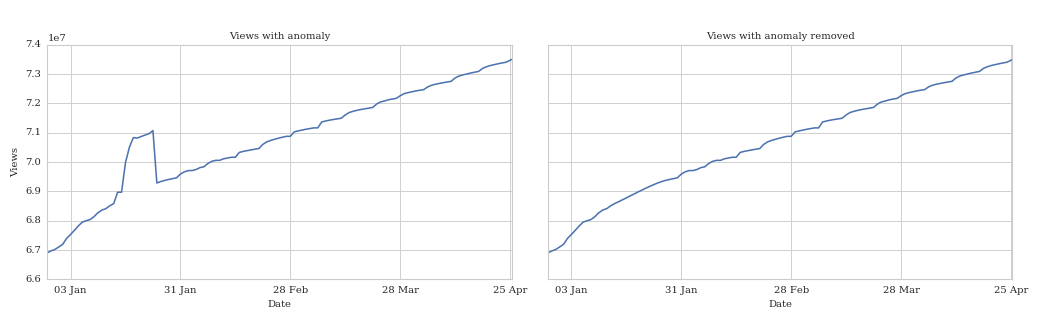

<IPython.core.display.Javascript object>


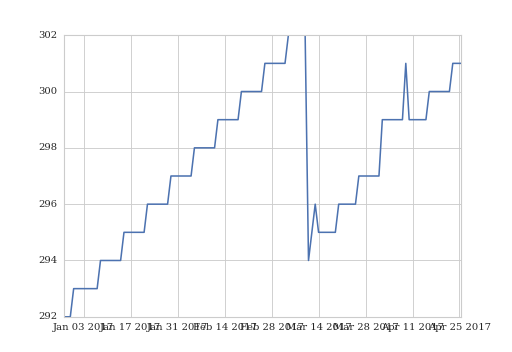

In [37]:
# sample removal of bug in channel viewcounts
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

bug_group = channel_collabs_groups.get_group('UCavTVjugW1OejDAq0aDzdMw')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,4), sharey=True)
fmt = DateFormatter("%d %b")

ax1.plot_date(bug_group['crawlTimestamp'], bug_group['viewCount'], 'b-')
ax1.set_xlabel('Date')
ax2.set_xlabel('Date')
ax1.set_ylabel('Views')

ax1.set_title('Views with anomaly')
ax2.set_title('Views with anomaly removed')

plt.legend()
ax1.xaxis.set_major_formatter(fmt)

# fixing
bug_value = bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 24), 'viewCount'].item() - bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 25), 'viewCount'].item()

bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 19), 'viewCount'] = bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 19), 'viewCount'] - bug_value

bug_group.ix[(bug_group.crawlTimestamp > "2017-01-15") & (bug_group.crawlTimestamp < "2017-01-19"), 'viewCount'] = np.nan
bug_group.ix[(bug_group.crawlTimestamp > "2017-01-19") & (bug_group.crawlTimestamp < "2017-01-25"), 'viewCount'] = np.nan

bug_group.ix[:,'viewCount'] = bug_group['viewCount'].interpolate(method='cubic')

ax2.plot_date(bug_group['crawlTimestamp'], bug_group['viewCount'], 'b-')
ax1.set_xticks(ax1.get_xticks()[::2])
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.xaxis.set_major_formatter(fmt)
#ax2.tick_params(axis='x', pad=15)
plt.subplots_adjust(left=0.6, bottom=None, right=None, top=None, wspace=None, hspace=None)
#plt.suptitle('Sample Video Views')
plt.tight_layout()
fig.subplots_adjust(top=0.86)
#save_plot('channel_viewcount_anomaly_sample.pdf', fig, 2*s_width, s_height)


fig, axs = plt.subplots()
axs.plot_date(bug_group['crawlTimestamp'], bug_group['videoCount'], 'b-')

In [38]:
# remove viewcount anomaly so it can be used for boxplots etc.
# collab channel list

for name, bug_group in channel_collabs_groups:

    # fixing
    try:
        bug_value = bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 24), 'viewCount'].item() - bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 25), 'viewCount'].item()
    except:
        print bug_group.crawlTimestamp
    
    bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 19), 'viewCount'] = bug_group.ix[bug_group.crawlTimestamp.dt.date == date(2017, 1, 19), 'viewCount'] - bug_value

    bug_group.ix[(bug_group.crawlTimestamp > "2017-01-15") & (bug_group.crawlTimestamp < "2017-01-19"), 'viewCount'] = np.nan
    bug_group.ix[(bug_group.crawlTimestamp > "2017-01-19") & (bug_group.crawlTimestamp < "2017-01-25"), 'viewCount'] = np.nan

    bug_group.ix[:,'viewCount'] = bug_group['viewCount'].interpolate(method='cubic')

    df_channel_history_collabs.ix[bug_group.index, 'viewCount'] = bug_group['viewCount']

id
6683     2016-12-28 03:02:19
14636    2016-12-29 00:05:18
22587    2016-12-30 00:05:11
30538    2016-12-31 00:05:10
38488    2017-01-01 00:05:15
46440    2017-01-02 00:05:14
54391    2017-01-03 00:05:12
62342    2017-01-04 00:05:11
70295    2017-01-05 00:05:10
78244    2017-01-06 00:04:49
86193    2017-01-07 00:04:46
94143    2017-01-08 00:05:03
102093   2017-01-09 00:06:13
110164   2017-01-10 00:06:17
118105   2017-01-10 01:44:57
126043   2017-01-11 00:06:02
133981   2017-01-12 00:06:04
141920   2017-01-13 00:06:04
149858   2017-01-14 00:06:02
157796   2017-01-15 00:06:01
165733   2017-01-16 00:06:37
173670   2017-01-17 00:06:31
181607   2017-01-18 00:06:26
189539   2017-01-19 00:06:18
609240   2017-03-13 00:05:54
617157   2017-03-14 00:05:55
625066   2017-03-15 00:06:03
632975   2017-03-16 00:06:09
640883   2017-03-17 00:05:53
648790   2017-03-18 00:06:06
                 ...        
712025   2017-03-26 00:06:48
719921   2017-03-27 00:06:27
727824   2017-03-28 00:06:41
735718   20

<IPython.core.display.Javascript object>


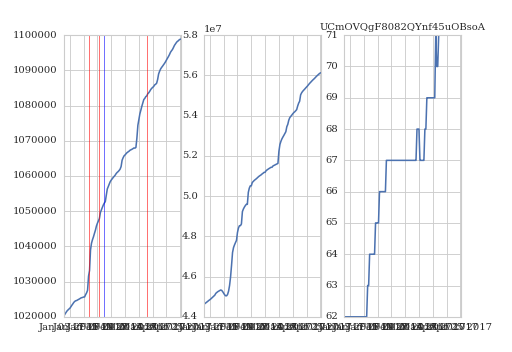

[u'-bDTvzpxatw', u'DFEccuZ7Os0', u'n8Fssy2_Chk']
-bDTvzpxatw
2017-01-22T19:54:21.000Z 4 ( 4 )
DFEccuZ7Os0
2017-02-01T18:20:59.000Z 4 ( 4 )
n8Fssy2_Chk
2017-03-21T18:15:59.000Z 4 ( 4 )
[u'5SzX4CWF_YE']
5SzX4CWF_YE
2017-02-06T17:00:00.000Z 3 ( 4 )


<IPython.core.display.Javascript object>


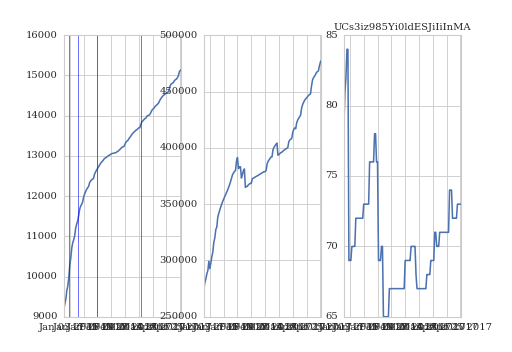

[u'CCRPPZh8odU', u'rqUlwmpJ1AA', u'zSx-e8TTXig']
CCRPPZh8odU
2017-01-01T16:30:00.000Z 2 ( 1 )
rqUlwmpJ1AA
2017-03-15T16:30:02.000Z 2 ( 1 )
zSx-e8TTXig
2017-01-11T16:30:01.000Z 2 ( 1 )
[u'Y9u0MoVwiDg']
Y9u0MoVwiDg
2017-01-30T13:00:18.000Z 1 ( 1 )


<IPython.core.display.Javascript object>


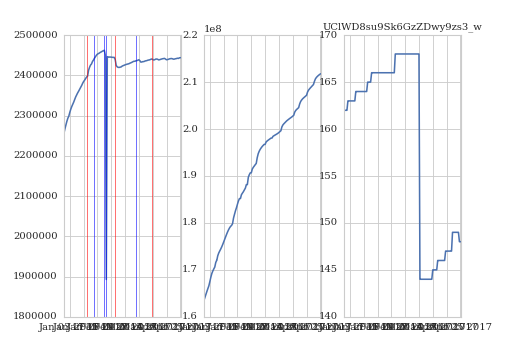

[u'30tEeFc34x4', u'Fazh9Lm1kDE', u'Vebn7K_0XDQ']
30tEeFc34x4
2017-03-27T19:00:01.000Z 3 ( 4 )
Fazh9Lm1kDE
2017-02-17T21:24:52.000Z 3 ( 4 )
Vebn7K_0XDQ
2017-01-20T20:00:01.000Z 3 ( 4 )
[u'Efvdo7kBL2c']
Efvdo7kBL2c
2017-03-10T18:30:06.000Z 3 ( 4 )
[u'N8vaJaFCFYA']
N8vaJaFCFYA
2017-02-06T23:11:25.000Z 4 ( 4 )
[u'bHUZcJgoxgk']
bHUZcJgoxgk
2017-02-08T22:00:02.000Z 4 ( 4 )
[u'9PyZBlrlWo8']
9PyZBlrlWo8
2017-01-27T21:02:28.000Z 1 ( 4 )


<IPython.core.display.Javascript object>


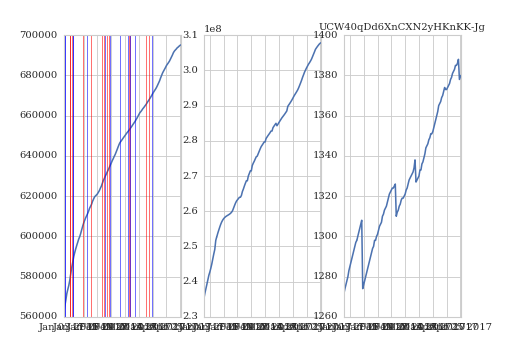

[u'gYoMjePTrW0', u'h_XRarrWWFg']
gYoMjePTrW0
2017-01-05T17:30:01.000Z 3 ( 3 )
h_XRarrWWFg
2017-01-02T17:30:30.000Z 3 ( 3 )
[u'A_aXshSgw7A', u'Q81OoD5HXcg', u'lPZzl-nr3eY']
A_aXshSgw7A
2017-02-11T21:30:00.000Z 4 ( 3 )
Q81OoD5HXcg
2017-03-23T21:30:00.000Z 4 ( 3 )
lPZzl-nr3eY
2017-01-02T21:30:01.000Z 4 ( 3 )
[u'epzfjF7WGWA', u'nTDfpcVkKuQ']
epzfjF7WGWA
2017-02-09T17:30:01.000Z 3 ( 3 )
nTDfpcVkKuQ
2017-02-04T17:30:00.000Z 3 ( 3 )
[u'LKaBzBT0daQ', u'_snh91PrFoY', u'oxpgEzA2UWY']
LKaBzBT0daQ
2017-03-21T17:30:01.000Z 3 ( 3 )
_snh91PrFoY
2017-03-03T21:30:02.000Z 3 ( 3 )
oxpgEzA2UWY
2017-01-24T21:30:01.000Z 3 ( 3 )
[u'_SN10Nd9FP4', u'kB5MlEEQUxs']
_SN10Nd9FP4
2017-03-04T21:30:01.000Z 3 ( 3 )
kB5MlEEQUxs
2017-01-15T21:30:00.000Z 3 ( 3 )
[u'dHQBS6Fyq-o']
dHQBS6Fyq-o
2017-02-06T17:30:01.000Z 3 ( 3 )
[u'Bt2bWNwREoU', u'LGVSyz1zVwE', u'NTFb1iAlcdc', u'T2BAKiLwnx0', u'Wi0oWHZQciw']
Bt2bWNwREoU
2017-01-20T18:00:05.000Z 3 ( 3 )
LGVSyz1zVwE
2017-02-22T18:00:17.000Z 3 ( 3 )
NTFb1iAlcdc
2017-03-09T18:48:3

<IPython.core.display.Javascript object>


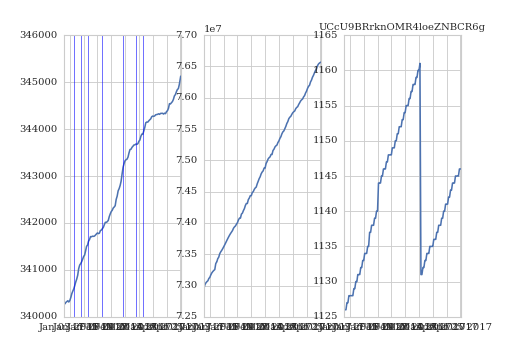

[u'E0e0DY2IpUs', u'JtUmEv2Kc2U', u'M8U0hkgZejU', u'OzeYibphCD4', u'QgXCXxMhV1s', u'TFribXd6_bQ', u'hqJMTcRLBYc']
E0e0DY2IpUs
2017-03-11T12:30:00.000Z 2 ( 3 )
JtUmEv2Kc2U
2017-03-18T12:30:02.000Z 2 ( 3 )
M8U0hkgZejU
2017-02-04T12:30:00.000Z 2 ( 3 )
OzeYibphCD4
2017-02-25T12:30:00.000Z 2 ( 3 )
QgXCXxMhV1s
2017-01-21T12:30:01.000Z 2 ( 3 )
TFribXd6_bQ
2017-01-07T12:30:01.000Z 2 ( 3 )
hqJMTcRLBYc
2017-01-14T12:30:00.000Z 2 ( 3 )


<IPython.core.display.Javascript object>


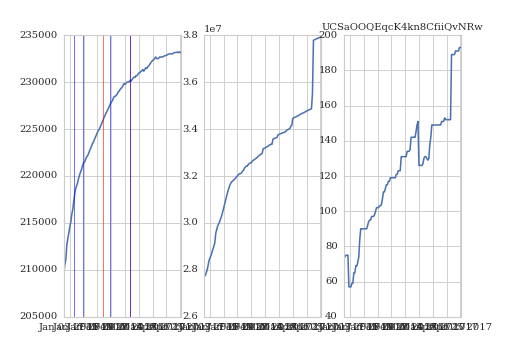

[u'HvLDfZvCsX0']
HvLDfZvCsX0
2017-03-04T19:24:29.000Z 4 ( 3 )
[u'buRMAAROJXQ']
buRMAAROJXQ
2017-02-05T21:05:50.000Z 0 ( 3 )
[u'_SN10Nd9FP4', u'kB5MlEEQUxs']
_SN10Nd9FP4
2017-03-04T21:30:01.000Z 3 ( 3 )
kB5MlEEQUxs
2017-01-15T21:30:00.000Z 3 ( 3 )
[u'MY5CKpMdXU0', u'vjibmmMPljY']
MY5CKpMdXU0
2017-01-07T15:23:08.000Z 4 ( 3 )
vjibmmMPljY
2017-02-12T19:30:01.000Z 4 ( 3 )


<IPython.core.display.Javascript object>


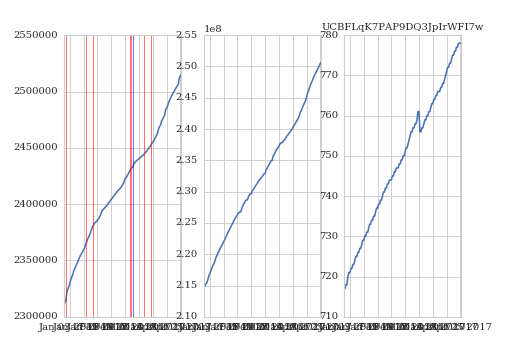

[u'8S6m_4iieKU']
8S6m_4iieKU
2017-03-04T20:56:31.000Z 2 ( 4 )
[u'HWYs3SWMTZU']
HWYs3SWMTZU
2016-12-29T20:00:00.000Z 4 ( 4 )
[u'FG0f06nyLFc']
FG0f06nyLFc
2017-01-19T20:00:00.000Z 4 ( 4 )
[u'ed0GP-dM2Q4']
ed0GP-dM2Q4
2017-01-26T20:00:00.000Z 3 ( 4 )
[u'2ya_bh8Y170', u'mfyV4ZlbYMg', u'n9x7-2esT2c']
2ya_bh8Y170
2017-03-26T14:00:00.000Z 3 ( 4 )
mfyV4ZlbYMg
2017-03-19T14:00:03.000Z 3 ( 4 )
n9x7-2esT2c
2017-03-05T14:00:03.000Z 3 ( 4 )
[u'9UkAdRJGDXQ']
9UkAdRJGDXQ
2017-03-07T18:58:09.000Z 2 ( 4 )


<IPython.core.display.Javascript object>


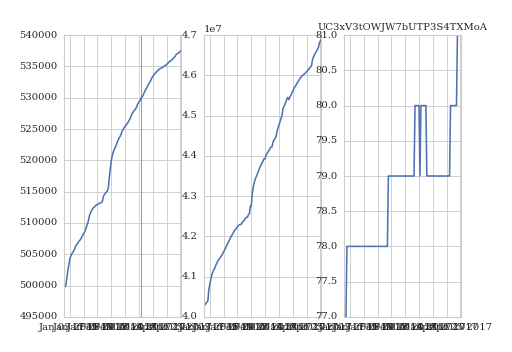

[u'EwsHT9ofHyY']
EwsHT9ofHyY
2017-03-15T17:28:36.000Z 2 ( 3 )


<IPython.core.display.Javascript object>


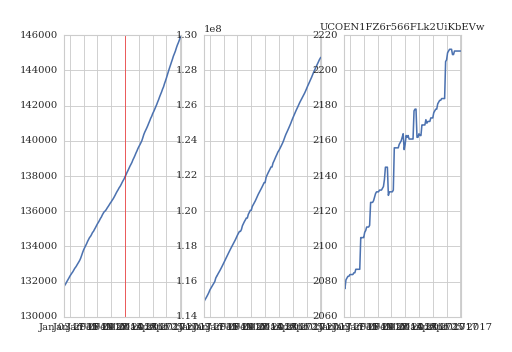

[u'e_GK6Rc9F8A']
e_GK6Rc9F8A
2017-02-28T01:17:24.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


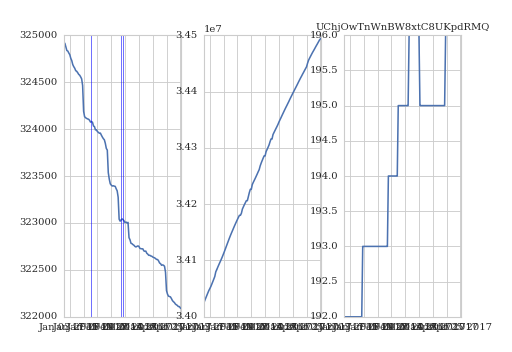

[u'bo7zp4kclTw']
bo7zp4kclTw
2017-02-26T07:55:45.000Z 3 ( 3 )
[u'XgIbvvjKYYY']
XgIbvvjKYYY
2017-02-23T18:00:04.000Z 4 ( 3 )
[u'qXAF3v1Polg']
qXAF3v1Polg
2017-01-24T01:38:43.000Z 4 ( 3 )


In [39]:
# print viewcounts for test
# sample channel statistics
import random


sampled_df_i  = random.sample(channel_collabs_groups.indices, 10)
df_list  = map(lambda df_i: (df_i, channel_collabs_groups.get_group(df_i)), sampled_df_i)

for name, group in df_list:
    #print name
    fig, axs = plt.subplots(ncols=3, )
    plt.title(name)
    axs[0].plot_date(group['crawlTimestamp'], group['subscriberCount'], 'b-')
    axs[1].plot_date(group['crawlTimestamp'], group['viewCount'], 'b-')
    axs[2].plot_date(group['crawlTimestamp'], group['videoCount'], 'b-')
    
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            print row.videos
            for vid in row['videos']:
                print vid
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                print date, str(row['from_popularity']), '(',row['to_popularity'], ')'
                axs[0].axvline(x=date, color='red', linewidth=.5)

        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            print row.videos
            for vid in row['videos']:
                print vid
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                print date, str(row['to_popularity']), '(',row['from_popularity'], ')'
                axs[0].axvline(x=date, color='blue', linewidth=.5)


<IPython.core.display.Javascript object>


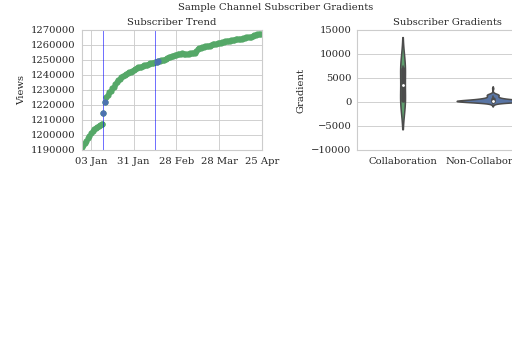

UCavTVjugW1OejDAq0aDzdMw
2017-01-10T17:09:15.000Z 6 ( 4 )
2017-02-14T05:12:46.000Z 3 ( 4 )


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [40]:
# KickthePJ channel subscriberCount plot, boxplot test

name = 'UCavTVjugW1OejDAq0aDzdMw'
group = channel_collabs_groups.get_group(name)

videos = []
fig, (ax1, ax2) = plt.subplots(ncols=2)
plt.title(name)
print name
ax1.plot_date(group['crawlTimestamp'], group['subscriberCount'], 'go', label='Subscriber')
label=True
with db._session_scope(False) as session:
    # own videos
    for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
        #print row.videos
        for vid in row['videos']:
            date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
            print date, str(row['from_popularity']), '(',row['to_popularity'], ')'
            ax1.axvline(x=date, color='blue', linewidth=.5, label="Collaboration" if label else "")
            label = False
            videos.append( (vid, date) )


    # external videos (hes in)
    for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
        #print row.videos
        for vid in row['videos']:
            date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
            print date, str(row['to_popularity']), '(',row['from_popularity'], ')'
            ax1.axvline(x=date, color='blue', linewidth=.5, label="Collaboration" if label else "")
            label = False
            videos.append( (vid, date) )


            
df_group_videos = pa.DataFrame(videos, columns=['video', 'date'])

subs = group['subscriberCount'].values
group.drop(group.index[:1], inplace=True)

group['gradient'] = np.diff(subs)
group['collab_window'] = 'Non_Collab'

df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))

label=True
for index, row in df_group_videos.iterrows():
    date, date_plus = row['date'], row['date_plus']
    filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
    group.ix[filtered.index, 'collab_window'] = 'Collab'
             
    ax1.plot(filtered['crawlTimestamp'], filtered['subscriberCount'], 'bo', label="Collaboration Window" if label else "")
    label = False
    #ax1.axvline(x=date, color='green', linewidth=.5)
    #ax1.axvline(x=date_plus, color='green', linewidth=.5)
    
sns.violinplot(x="collab_window", y="gradient", data=group, ax=ax2, order=['Collab', 'Non_Collab'])

ax1.set_xlabel('Date')
ax1.set_ylabel('Views')
fmt = DateFormatter("%d %b")
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.xaxis.set_major_formatter(fmt)
ax1.legend(bbox_to_anchor=(0.6, -0.6), loc=3)

ax1.set_title('Subscriber Trend')
ax2.set_title('Subscriber Gradients')
ax2.set_ylabel('Gradient')
ax2.set_xlabel('')
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
plt.suptitle('Sample Channel Subscriber Gradients')
fig.tight_layout()
fig.subplots_adjust(top=0.82)

save_plot('channel_subscriber_gradient_sample_violin.pdf', fig, 2*s_width, s_height)


<IPython.core.display.Javascript object>


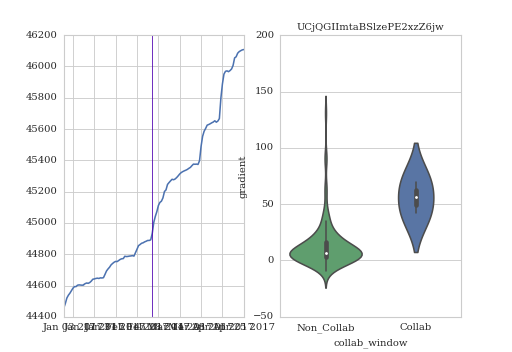

UCjQGIImtaBSlzePE2xzZ6jw
2017-02-23T20:36:23.000Z 3 ( 2 )
2017-02-23T20:30:00.000Z 3 ( 2 )


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

<IPython.core.display.Javascript object>


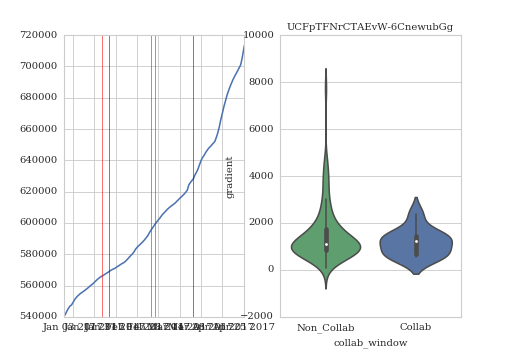

UCFpTFNrCTAEvW-6CnewubGg
2017-01-21T20:59:43.000Z 2 ( 3 )
2017-02-25T16:00:24.000Z 3 ( 3 )
2017-02-22T21:26:45.000Z 4 ( 3 )
2017-03-22T21:57:09.000Z 3 ( 3 )
2017-01-26T17:00:01.000Z 2 ( 3 )


<IPython.core.display.Javascript object>


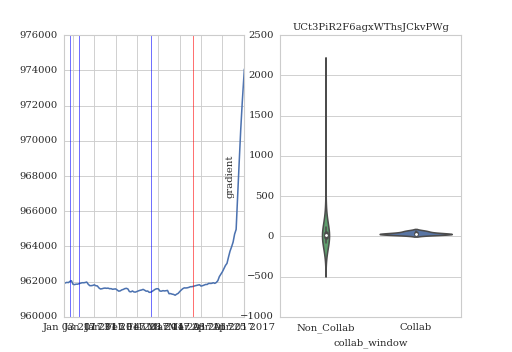

UCt3PiR2F6agxWThsJCkvPWg
2017-03-22T17:12:58.000Z 1 ( 3 )
2016-12-31T20:05:26.000Z 4 ( 3 )
2017-02-23T00:07:06.000Z 4 ( 3 )
2017-01-06T16:30:01.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


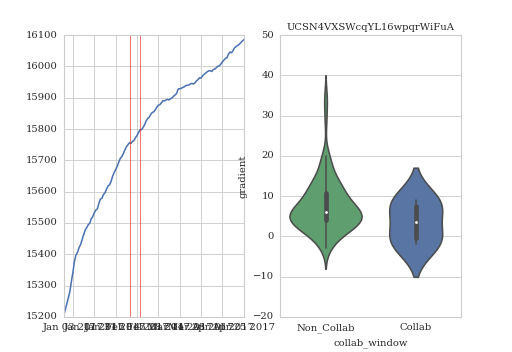

UCSN4VXSWcqYL16wpqrWiFuA
2017-02-15T18:29:25.000Z 3 ( 2 )
2017-02-09T14:17:58.000Z 3 ( 2 )


<IPython.core.display.Javascript object>


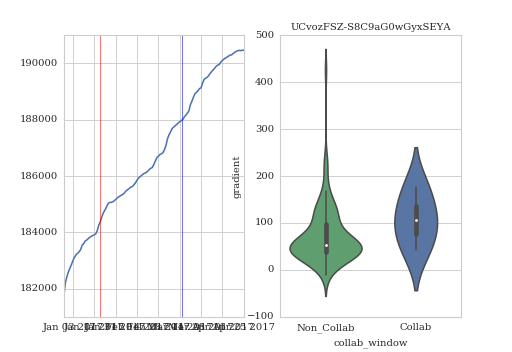

UCvozFSZ-S8C9aG0wGyxSEYA
2017-01-20T17:01:26.000Z 4 ( 3 )
2017-03-15T17:00:05.000Z 4 ( 3 )


<IPython.core.display.Javascript object>


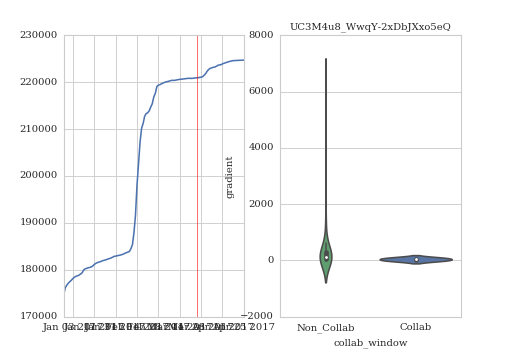

UC3M4u8_WwqY-2xDbJXxo5eQ
2017-03-25T11:29:30.000Z 2 ( 3 )


<IPython.core.display.Javascript object>


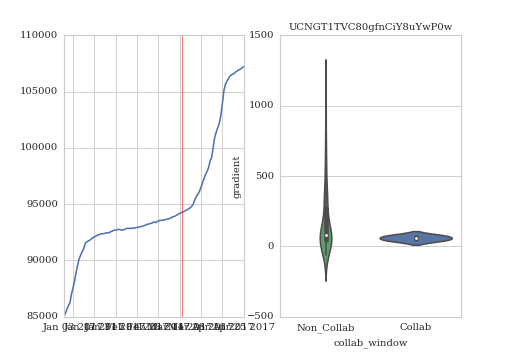

UCNGT1TVC80gfnCiY8uYwP0w
2017-03-15T14:10:31.000Z 3 ( 2 )


<IPython.core.display.Javascript object>


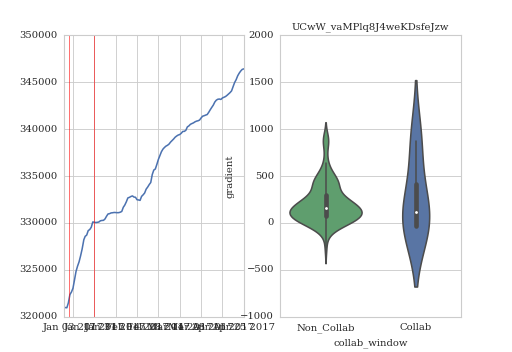

UCwW_vaMPlq8J4weKDsfeJzw
2016-12-31T12:05:45.000Z 2 ( 3 )
2017-01-16T17:08:13.000Z 3 ( 3 )


<IPython.core.display.Javascript object>


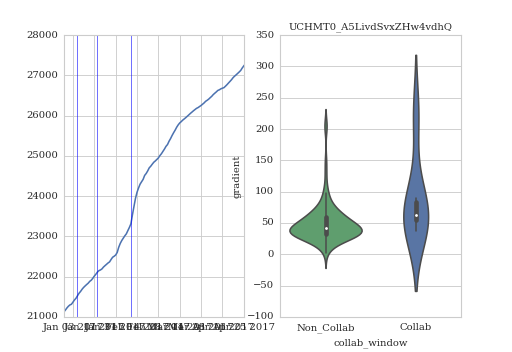

UCHMT0_A5LivdSvxZHw4vdhQ
2017-01-18T20:47:01.000Z 3 ( 2 )
2017-01-05T23:01:39.000Z 3 ( 2 )
2017-02-09T23:00:19.000Z 3 ( 2 )


<IPython.core.display.Javascript object>


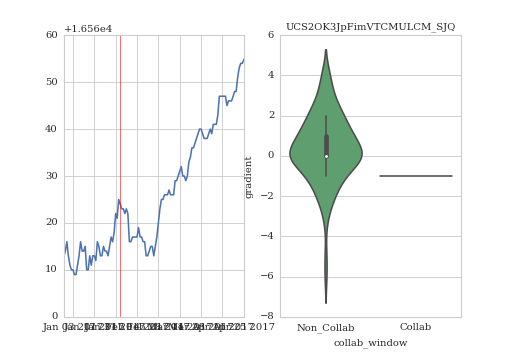

UCS2OK3JpFimVTCMULCM_SJQ
2017-02-02T19:24:45.000Z 2 ( 2 )


In [41]:
import random


sampled_df_i  = random.sample(channel_collabs_groups.indices, 10)
df_list  = map(lambda df_i: (df_i, channel_collabs_groups.get_group(df_i)), sampled_df_i)


for name, group in df_list:
    videos = []
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    plt.title(name)
    print name
    ax1.plot_date(group['crawlTimestamp'], group['subscriberCount'], 'b-')
    
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                print date, str(row['from_popularity']), '(',row['to_popularity'], ')'
                ax1.axvline(x=date, color='red', linewidth=.5)
                videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                print date, str(row['to_popularity']), '(',row['from_popularity'], ')'
                ax1.axvline(x=date, color='blue', linewidth=.5)
                videos.append( (vid, date) )

    df_group_videos = pa.DataFrame(videos, columns=['video', 'date'])

    subs = group['subscriberCount'].values
    group.drop(group.index[:1], inplace=True)
    group['gradient'] = np.diff(subs)
    group['collab_window'] = 'Non_Collab'
    
    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))


    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        group.ix[filtered.index, 'collab_window'] = 'Collab'
    
    sns.violinplot(x="collab_window", y="gradient", data=group, ax=ax2) #, order=["Collab", "Non_Collab"])


In [42]:
# fixing zeros in subscriber count for division by zero

for name, group in channel_collabs_groups:
    if 0 in group['subscriberCount'].values:
        print name
        print group['subscriberCount'].values

group = channel_collabs_groups.get_group('UCAvwetms56ntZtQWkYoqEIQ')
subs = group['subscriberCount'].values
subs[subs == 0] = 572346
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCCnms8EieLvB6oNLXBgIGNQ')
subs = group['subscriberCount'].values
subs[subs == 0] = 146262
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs


#group = channel_collabs_groups.get_group('UCe4Qc872PPFvqHam6ZhSvTA')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 6523
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCeIKuNTuMAUWBuWcY8R3sRw')
subs = group['subscriberCount'].values
subs[subs == 0] = 43343
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCfSkUDlRZMP4oH3dKNlrsUw')
subs = group['subscriberCount'].values
subs[subs == 0] = 8837
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCfWqafyV4h6S_U_QpjT-6Ew')
subs = group['subscriberCount'].values
subs[subs == 0] = 961294
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

#group = channel_collabs_groups.get_group('UCjTozZ9pnenz_Yb8_AYeNDw')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 181349
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

#group = channel_collabs_groups.get_group('UCmbqnC6-ERzFmJZ6Ww2oDzQ')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 158
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCtixLHW0DJpVF6RBpLvGLhw')
subs = group['subscriberCount'].values
subs[subs == 0] = 224791
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCzIzWHfn7wsS_VK0vQHV8Ew')
subs = group['subscriberCount'].values
subs[subs == 0] = 112018
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UC3gIT-1j10zNwtHS9gEqirQ')
subs = group['subscriberCount'].values
subs[subs == 0] = 375497
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs


group = channel_collabs_groups.get_group('UC7LRYRh6ZK12Ll65sv31C1A')
subs = group['subscriberCount'].values
subs[subs == 0] = 549589
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCBq6jERElPLXL5cEy-sA9Tw')
subs = group['subscriberCount'].values
subs[subs == 0] = 25775
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs


group = channel_collabs_groups.get_group('UCDbLXOPZhm6BcQzAhZ8Wbrg')
subs = group['subscriberCount'].values
subs[subs == 0] = 34261
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs
 

group = channel_collabs_groups.get_group('UC3gIT-1j10zNwtHS9gEqirQ')
subs = group['subscriberCount'].values
subs[subs == 0] = 375497
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UC7LRYRh6ZK12Ll65sv31C1A')
subs = group['subscriberCount'].values
subs[subs == 0] = 549589
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

#group = channel_collabs_groups.get_group('UCB7t5OLatzbcrzwee42xX6A')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 96117
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs
 
    
#group = channel_collabs_groups.get_group('UCCK5pW50ZSjjAioPAFY21Hw')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 83
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCBq6jERElPLXL5cEy-sA9Tw')
subs = group['subscriberCount'].values
subs[subs == 0] = 25775
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCDbLXOPZhm6BcQzAhZ8Wbrg')
subs = group['subscriberCount'].values
subs[subs == 0] = 33013
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs



group = channel_collabs_groups.get_group('UCGyuI1F-x984sntQLqKpCGQ')
subs = group['subscriberCount'].values
subs[subs == 0] = 215796
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs
 
#group = channel_collabs_groups.get_group('UCKz3OeIKQnGpLrU4jCc4RtA')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 2541
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCMF6uNnBsB2nd9U7ubSOMCg')
subs = group['subscriberCount'].values
subs[subs == 0] = 6692
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCQVhJlOmUspW5n5dihNK5nA')
subs = group['subscriberCount'].values
subs[subs == 0] = 1009
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

group = channel_collabs_groups.get_group('UCRhHwyC680T6vGBfHdKDvMA')
subs = group['subscriberCount'].values
subs[subs == 0] = 378207
df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

#group = channel_collabs_groups.get_group('UCSJqpx0_j0zC21zl25pqjOg')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 227299
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

#group = channel_collabs_groups.get_group('UCX8sAJmvoXNPFDO2Ohe9e-w')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 19018
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

#group = channel_collabs_groups.get_group('UCYPe4nOymFwkoG3GxIFc5YQ')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 510583
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

#group = channel_collabs_groups.get_group('UCaUwlJEE3Vxsw0eIG15xBiw')
#subs = group['subscriberCount'].values
#subs[subs == 0] = 80516
#df_channel_history_collabs.ix[group.index, 'subscriberCount'] = subs

UC3gIT-1j10zNwtHS9gEqirQ
[375497      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]
UC7LRYRh6ZK12Ll65sv31C1A
[289010 292699 295493 297472 298875 299928 301325 305364 309657 311833
 313833 315548 317834 3200

In [43]:
# compute subscriber gradient and gradient percentage growth and collaboration window in dataframe

df_channel_history_collabs['gradient'] = np.nan
df_channel_history_collabs['p_gradient'] = np.nan
df_channel_history_collabs['collab_window'] = 'NaN'


for name, group in channel_collabs_groups:
    collab_videos = []
    norm_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]


    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])


    subs = group['subscriberCount'].values
    #subs = np.insert(subs, 0, subs[0])
    group.drop(group.index[:1], inplace=True)
    df_channel_history_collabs.ix[group.index, 'gradient'] = np.diff(subs)
    df_channel_history_collabs.ix[group.index, 'p_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(subs[1:], subs)]
    
    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))
    
    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=2))

    
    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        df_channel_history_collabs.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        if (df_channel_history_collabs.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_channel_history_collabs.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_channel_history_collabs.ix[filtered.index, 'collab_window'] = 'Collab'
        
    

print 'Non_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_gradient'].describe()

print '\nNaN:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='NaN']['gradient'].describe()
print '\nNaN:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='NaN']['p_gradient'].describe()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Non_Collabs:
count     78877.000000
mean       1129.936927
std        3978.492095
min     -313264.000000
25%          53.000000
50%         266.000000
75%         954.000000
max      644558.000000
Name: gradient, dtype: float64

Collabs:
count      9086.000000
mean       1385.290447
std        9306.484827
min     -557555.000000
25%          41.000000
50%         267.000000
75%        1103.000000
max      553899.000000
Name: gradient, dtype: float64

Non_Collabs:
count    78877.000000
mean         0.236285
std          5.807266
min         -3.297110
25%          0.041117
50%          0.107116
75%          0.233259
max       1623.611111
Name: p_gradient, dtype: float64

Collabs:
count    9086.000000
mean        0.265093
std         0.995164
min       -22.754245
25%         0.029407
50%         0.089514
75%         0.238963
max        31.533029
Name: p_gradient, dtype: float64

NaN:
count    101758.000000
mean        599.984650
std        1861.136252
min      -33010.000000
25%          13

In [ ]:
len(df_channel_history_collabs[df_channel_history_collabs.gradient.isnull()])


In [61]:
# fixing zeros in view count for division by zero
# no found atm

for name, group in channel_collabs_groups:
    if 0 in group['viewCount'].values:
        vals = group['viewCount'].values
        i = np.where(vals == 0)[0]
        vals[i] = vals[i-1]
        df_channel_history_collabs.ix[group.index, 'viewCount'] = vals

In [62]:
for name, group in channel_collabs_groups:
    if 0 in group['viewCount'].values:
        print name
        print group['viewCount'].values

In [63]:
# compute viewcount gradient and percentage gradient for channel

df_channel_history_collabs['viewCount_gradient'] = np.nan
df_channel_history_collabs['p_viewCount_gradient'] = np.nan

for name, group in channel_collabs_groups:
    views = group['viewCount'].values
    group.drop(group.index[:1], inplace=True)
    df_channel_history_collabs.ix[group.index, 'viewCount_gradient'] = np.diff(views)
    df_channel_history_collabs.ix[group.index, 'p_viewCount_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(views[1:], views)]


print 'Non_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['viewCount_gradient'].describe()

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_viewCount_gradient'].describe()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Non_Collabs:
count    7.887700e+04
mean     2.971154e+05
std      8.724060e+06
min     -2.371137e+09
25%      1.146000e+04
50%      5.620000e+04
75%      2.270120e+05
max      3.529542e+08
Name: viewCount_gradient, dtype: float64

Collabs:
count    9.086000e+03
mean     2.527918e+05
std      6.418913e+05
min     -1.305142e+06
25%      6.300250e+03
50%      4.343650e+04
75%      1.901478e+05
max      1.494551e+07
Name: viewCount_gradient, dtype: float64

Non_Collabs:
count    78877.000000
mean         0.282581
std          2.823960
min        -76.880238
25%          0.072117
50%          0.148560
75%          0.301936
max        550.616611
Name: p_viewCount_gradient, dtype: float64

Collabs:
count    9086.000000
mean        0.283491
std         1.247673
min       -79.616772
25%         0.055746
50%         0.125284
75%         0.292861
max        29.315961
Name: p_viewCount_gradient, dtype: float64


In [64]:
df_channel_history_collabs.to_csv(DIR+r'/df_channel_history_collabs.txt', sep=str('\t'), encoding='utf-8')
#df_channel_history_collabs = pa.read_csv(DIR+r'/df_channel_history_collabs.txt', sep=str('\t'), encoding='utf-8')

In [65]:
df_channel_history_collabs[df_channel_history_collabs.gradient.isnull()].head()

channelID    viewCount  subscriberCount  commentCount  \
id                                                                         
4   UC-63s9JLCZqIDlhXK6VHb7w    8834171.0            27606             0   
5   UC-4kjzuh4822B9yPSgpZQgA   28671226.0          1234411             0   
11  UC-A4oZF4AlOEdlyZWBCI0cQ  337690529.0          1642619          3676   
20  UC-aJ5-YxVUH77ro5MGJt7Dg   52026141.0           184264             0   
31  UC-CRXGRabkMD7x6V_Nk9F0A     474647.0             2852             0   

    videoCount      crawlTimestamp  gradient  p_gradient collab_window  \
id                                                                       
4           89 2016-12-28 02:57:14       NaN         NaN           NaN   
5           49 2016-12-28 02:57:14       NaN         NaN           NaN   
11         549 2016-12-28 02:57:14       NaN         NaN           NaN   
20         239 2016-12-28 02:57:14       NaN         NaN           NaN   
31         193 2016-12-28 02:57:15       NaN         NaN           NaN   

    viewCount_gradient  p_viewCount_gradient  
id                                            
4                  NaN                   NaN  
5                  NaN                   NaN  
11                 NaN                   NaN  
20                 NaN                   NaN  
31                 NaN                   NaN

In [66]:
df_channel_history_collabs[df_channel_history_collabs.p_gradient > 1000]

channelID  viewCount  subscriberCount  commentCount  \
id                                                                          
44365  UCmuBqEMBGe1SKWlF33JUz0w     1710.0             2482             0   

       videoCount      crawlTimestamp  gradient   p_gradient collab_window  \
id                                                                           
44365          19 2017-01-02 00:03:39    2338.0  1623.611111    Non_Collab   

       viewCount_gradient  p_viewCount_gradient  
id                                               
44365                11.0               0.64744

In [67]:
# remove single outlier testwise
df_channel_history_collabs.dropna(subset=['gradient', 'viewCount_gradient'], inplace=True)
df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs.p_gradient < 1000]
channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_gradient'].describe()


Non_Collabs:
count    78876.000000
mean         0.215704
std          0.559166
min         -3.297110
25%          0.041116
50%          0.107113
75%          0.233258
max         60.072522
Name: p_gradient, dtype: float64

Collabs:
count    9086.000000
mean        0.265093
std         0.995164
min       -22.754245
25%         0.029407
50%         0.089514
75%         0.238963
max        31.533029
Name: p_gradient, dtype: float64


In [68]:
df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs.p_viewCount_gradient < 100]

In [69]:
#df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs.p_viewCount_gradient < 200]
#df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs.viewCount_gradient < 1.0e+08]
channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])

print '\nNon_Collabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Non_Collab']['p_viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs[df_channel_history_collabs.collab_window=='Collab']['p_viewCount_gradient'].describe()


Non_Collabs:
count    78869.000000
mean         0.261662
std          1.049669
min        -76.880238
25%          0.072101
50%          0.148523
75%          0.301837
max         72.233197
Name: p_viewCount_gradient, dtype: float64

Collabs:
count    9086.000000
mean        0.283491
std         1.247673
min       -79.616772
25%         0.055746
50%         0.125284
75%         0.292861
max        29.315961
Name: p_viewCount_gradient, dtype: float64


<IPython.core.display.Javascript object>


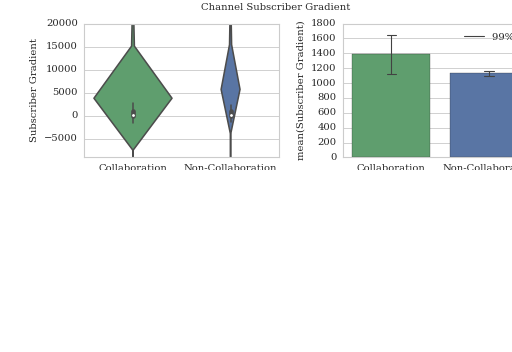

<IPython.core.display.Javascript object>


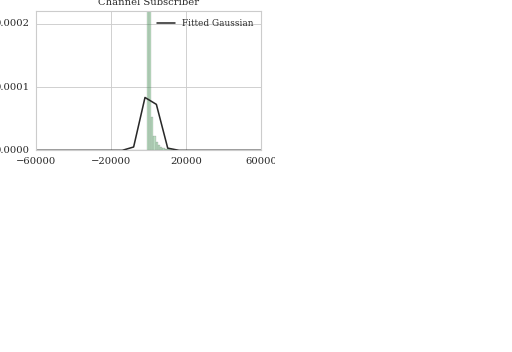

In [70]:
# Boxplot subscriberCount gradient for collab channel 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Subscriber Gradient')
ax2.set_ylabel('mean(Subscriber Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel Subscriber Gradient')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-9000.0, 20000.0])
save_plot('collab_channel_subscriber_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_channel_history_collabs[df_channel_history_collabs["gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['gradient'])

fig = plt.figure()
ax = sns.distplot(test['gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["$\mu=${0:.2g}, $\sigma=${1:.2f}".format(mu, sigma)])
#plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
ax.set_ylim([0.0, 0.00022])
ax.set_xlim([-60000.0, 60000.0])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_channel_subscriber_norm_fit.pdf', fig, s_width, s_height)
#print 'Normal-dist-test:', normaltest(test['gradient'])

collabs_grads = test[test.collab_window == 'Collab']['gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


<IPython.core.display.Javascript object>


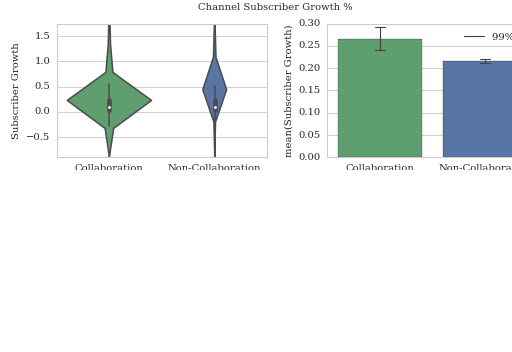

<IPython.core.display.Javascript object>


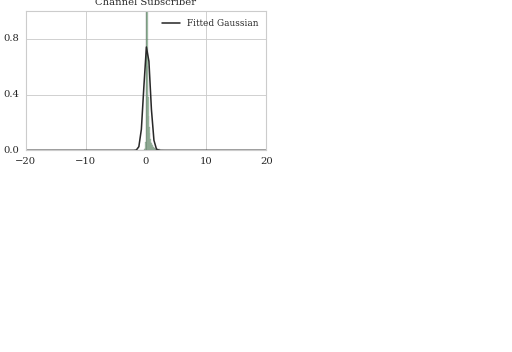

In [71]:
# Boxplot subscriberCount percentage gradient for collab channel 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Subscriber Growth')
ax2.set_ylabel('mean(Subscriber Growth)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel Subscriber Growth %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-0.9, 1.75])
save_plot('collab_channel_subscriber_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_channel_history_collabs[df_channel_history_collabs["p_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
plt.tight_layout()
ax.set_ylim([0.0, 1.0])
ax.set_xlim([-16.0, 16.0])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_channel_subscriber_norm_fit_perc.pdf', fig, s_width, s_height)

#print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


<IPython.core.display.Javascript object>


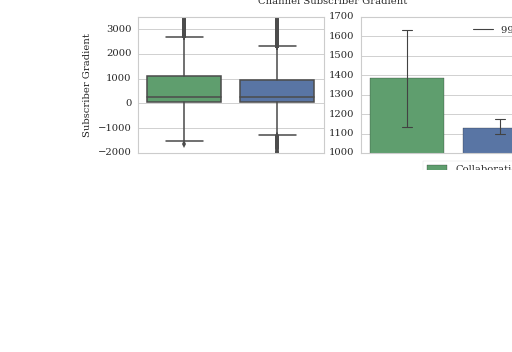

In [191]:
# combines plot of the two above

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
sns.boxplot(x="collab_window", y="gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
ax2.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Subscriber Gradient')
ax2.set_ylabel('')
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1.set_title('Channel Subscriber Gradient', x=1.05, y=1.05)
#fig.subplots_adjust(top=0.86)
ax1.set_ylim([-2000.0, 3500.0])
ax2.set_ylim([1000.0, 1700.0])

sns.boxplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs, ax=ax3, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax4, order=['Collab', 'Non_Collab'])
ax4.legend(["{}% CI".format(99)], bbox_to_anchor=(1.0, 1.05))
ax3.set_xlabel('')
ax4.set_xlabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax3.set_title('Channel Subscriber Growth %', x=1.05, y=1.05)
#fig.subplots_adjust(top=0.86)
ax3.set_ylim([-0.4, 0.6])
ax4.set_ylim([0.18, 0.30])

bars = [rect for rect in ax4.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
ax3.legend(frameon=True, handles=bars, labels=['Collaboration', 'Non-Collaboration'],loc='upper center', bbox_to_anchor=(-0.2, -0.02), ncol=2)

#fig.tight_layout()
save_plot('collab_channel_subscriber_box_ci_violin_combine_box.pdf', fig, 4*s_width, s_height)

In [73]:
print '\nCollab only channel'
print 'Number of values:', len(df_channel_history_collabs)
print 'Number of non_collab values:', len(df_channel_history_collabs[df_channel_history_collabs.collab_window == 'Non_Collab'])
print 'Number of collab values:', len(df_channel_history_collabs[df_channel_history_collabs.collab_window == 'Collab'])


Collab only channel
Number of values: 189710
Number of non_collab values: 78869
Number of collab values: 9086


<IPython.core.display.Javascript object>


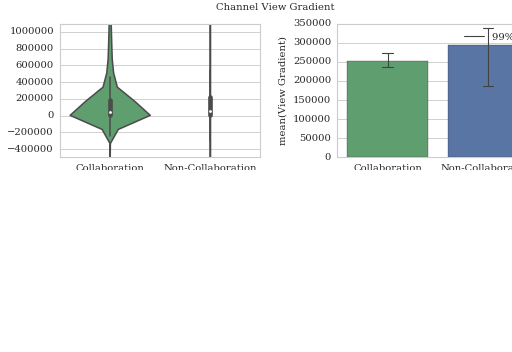

9086
78869


<IPython.core.display.Javascript object>


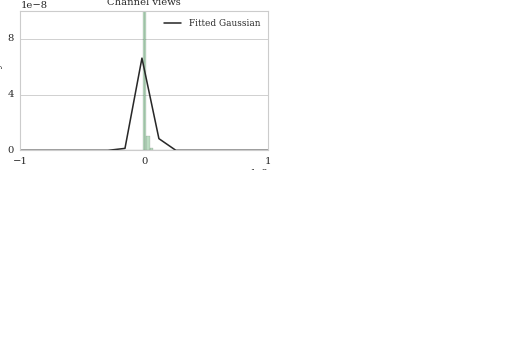

In [74]:
# Boxplot viewCount gradient for collab channel

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="viewCount_gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="viewCount_gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Gradient')
ax2.set_ylabel('mean(View Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel View Gradient')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-500000.0, 1100000.0])
save_plot('collab_channel_fixed_view_box_ci_violin.pdf', fig, 2*s_width, s_height)

print(len(df_channel_history_collabs[df_channel_history_collabs['collab_window']=='Collab']))
print(len(df_channel_history_collabs[df_channel_history_collabs['collab_window']=='Non_Collab']))

# test, norm fitting
test = df_channel_history_collabs[df_channel_history_collabs["viewCount_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['viewCount_gradient'])

fig = plt.figure()
ax = sns.distplot(test['viewCount_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
#plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Channel views')
plt.tight_layout()
ax.set_ylim([0.0, 10.0e-8])
ax.set_xlim([-1.0e+8, 1.0e+8])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_channel_fixed_view_norm_fit_perc.pdf', fig, s_width, s_height)
#print 'Normal-dist-test:', normaltest(test['viewCount_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['viewCount_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['viewCount_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


<IPython.core.display.Javascript object>


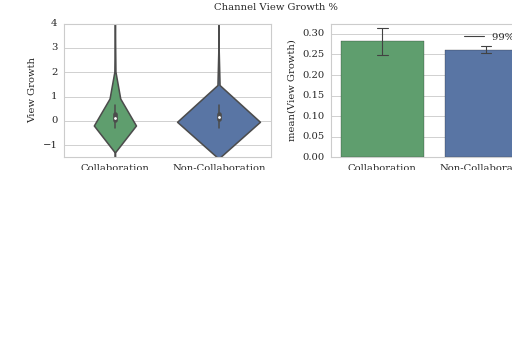

<IPython.core.display.Javascript object>


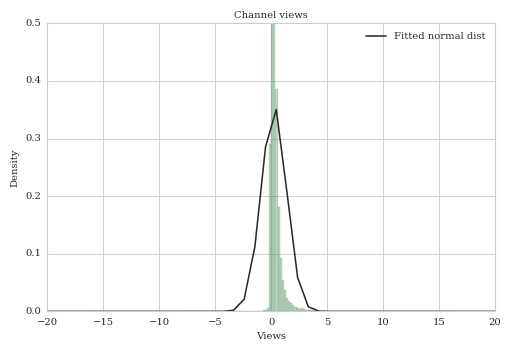

In [75]:
# Boxplot viewCount percentage gradient for collab channel

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_viewCount_gradient", data=df_channel_history_collabs, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_viewCount_gradient", data=df_channel_history_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Growth')
ax2.set_ylabel('mean(View Growth)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel View Growth %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-1.5, 04.00])
ax2.set_ylim([0.0, 00.325])
save_plot('collab_channel_fixed_view_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_channel_history_collabs[df_channel_history_collabs["p_viewCount_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_viewCount_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_viewCount_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
ax.set_xlim([-20.0, 20.00])
ax.set_ylim([0.0, 00.50])
plt.title('Channel views')
plt.tight_layout()

#print 'Normal-dist-test:', normaltest(test['p_viewCount_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_viewCount_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_viewCount_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


In [76]:
df_channel_history_collabs.head(5)

channelID    viewCount  subscriberCount  commentCount  \
id                                                                           
7956  UC-4kjzuh4822B9yPSgpZQgA   28931198.0          1238595             0   
7968  UC-63s9JLCZqIDlhXK6VHb7w    8835366.0            27605             0   
7970  UC-A4oZF4AlOEdlyZWBCI0cQ  337869772.0          1642804          3676   
7972  UC-aJ5-YxVUH77ro5MGJt7Dg   52265092.0           185099             0   
7983  UC-CRXGRabkMD7x6V_Nk9F0A     475640.0             2861             0   

      videoCount      crawlTimestamp  gradient  p_gradient collab_window  \
id                                                                         
7956          50 2016-12-29 00:00:03    4184.0    0.338947    Non_Collab   
7968          89 2016-12-29 00:00:03      -1.0   -0.003622           NaN   
7970         549 2016-12-29 00:00:04     185.0    0.011263           NaN   
7972         241 2016-12-29 00:00:04     835.0    0.453154    Non_Collab   
7983         193 2016-12-29 00:00:04       9.0    0.315568           NaN   

      viewCount_gradient  p_viewCount_gradient  
id                                              
7956            259972.0              0.906735  
7968              1195.0              0.013527  
7970            179243.0              0.053079  
7972            238951.0              0.459290  
7983               993.0              0.209208

In [77]:
# Try new method, instead of fixing the anomaly viewcount bug
# Use video view history to sum daily viewcount for every channel

# group history by channel
# group channel groups by day
# sum viewcount per day group -> daily viewcount per channel -> gradient

In [78]:
# Read history data from  DB
with db._session_scope(False) as session:

    df_video_history = pa.read_sql(session.query(VideoHistory, Video.channelID).filter(VideoHistory.videoID==Video.id).statement, db.engine)


df_video_history = df_video_history.set_index(['id'])
df_video_history['crawlTimestamp'] = df_video_history['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))


#df_video_history.head()

In [79]:
# Create new column with just crawl date (day, no time)
# so we can group all video viewcounts by day -> sum these
df_video_history['crawlDate'] = df_video_history['crawlTimestamp'].apply(lambda x: x.date())
df_video_history.head()

videoID  viewCount  commentCount  likeCount  dislikeCount  \
id                                                                       
2508759  _GDOhRsQ9KQ        125             0          6             0   
2611688  _GDOhRsQ9KQ        273             0          8             0   
2713841  _GDOhRsQ9KQ        327             0          9             0   
2817915  _GDOhRsQ9KQ        387             0          9             0   
2923911  _GDOhRsQ9KQ        471             0          9             0   

             crawlTimestamp                 channelID   crawlDate  
id                                                                 
2508759 2017-02-18 00:08:33  UC__Pj66OeDibNZNN__L913g  2017-02-18  
2611688 2017-02-19 00:16:59  UC__Pj66OeDibNZNN__L913g  2017-02-19  
2713841 2017-02-20 00:17:07  UC__Pj66OeDibNZNN__L913g  2017-02-20  
2817915 2017-02-21 00:15:05  UC__Pj66OeDibNZNN__L913g  2017-02-21  
2923911 2017-02-22 00:15:43  UC__Pj66OeDibNZNN__L913g  2017-02-22

In [80]:
# group by channel then by day, sum all daily view counts
# runs some time
video_channel_groups = df_video_history.groupby(['channelID'])

df_video_channel_viewcounts = []

for name, group in video_channel_groups:
    days = group.groupby(['crawlDate'])
    
    for dname, dgroup in days:
        df_video_channel_viewcounts.append( (name, dname, dgroup['viewCount'].sum()))
    

df_video_channel_viewcounts = pa.DataFrame(df_video_channel_viewcounts, columns=['channelID', 'date', 'viewCount'])

df_video_channel_viewcounts.head()


channelID        date  viewCount
0  UC--BMyA2X4a9PGAo3lTuopg  2017-01-31      13672
1  UC--BMyA2X4a9PGAo3lTuopg  2017-02-01     231441
2  UC--BMyA2X4a9PGAo3lTuopg  2017-02-02     366900
3  UC--BMyA2X4a9PGAo3lTuopg  2017-02-03     462052
4  UC--BMyA2X4a9PGAo3lTuopg  2017-02-04     527676

In [82]:
# save to file
df_video_channel_viewcounts.to_csv(DIR+r'/df_video_channel_viewcounts.txt', sep=str('\t'), encoding='utf-8')
#df_video_channel_viewcounts = pa.read_csv(DIR+r'/df_video_channel_viewcounts.txt', sep=str('\t'), encoding='utf-8', index_col=0)
#df_video_channel_viewcounts['date'] = df_video_channel_viewcounts['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

print 'Nof Value points in new videoviews based (All channel):', len(df_video_channel_viewcounts)
print df_video_channel_viewcounts['channelID'].nunique()

print 'Nof Value points in channel based (collab only channel):', len(df_channel_history_collabs)
print df_channel_history_collabs['channelID'].nunique()


df_video_channel_viewcounts_collabs = df_video_channel_viewcounts[ (df_video_channel_viewcounts.channelID.isin(df_graph_filtered['from'].tolist())) | (df_video_channel_viewcounts.channelID.isin(df_graph_filtered['to'].tolist()))]
print 'Nof Value points in new videoviews based (collab channel):', len(df_video_channel_viewcounts_collabs)
print df_video_channel_viewcounts_collabs['channelID'].nunique()

Nof Value points in new videoviews based (All channel): 593918
5831
Nof Value points in channel based (collab only channel): 189710
1599
Nof Value points in new videoviews based (collab channel): 175372
1599


<IPython.core.display.Javascript object>


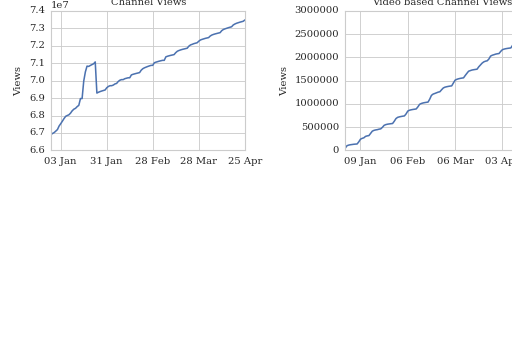

120
115


In [83]:
#bug_group = channel_collabs_groups.get_group('UCavTVjugW1OejDAq0aDzdMw')
bug_group = unfixed_channel_collabs_groups.get_group('UCavTVjugW1OejDAq0aDzdMw')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot_date(bug_group['crawlTimestamp'], bug_group['viewCount'], 'b-')
ax1.set_title('Channel Views')
video_views = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.channelID=='UCavTVjugW1OejDAq0aDzdMw']
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_xlabel('Date')
ax1.set_ylabel('Views')

ax2.plot_date(video_views['date'], video_views['viewCount'], 'b-')
ax2.set_title('Video based Channel Views')
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_xlabel('Date')
ax2.set_ylabel('Views')

fmt = DateFormatter("%d %b")
ax1.xaxis.set_major_formatter(fmt)
ax2.xaxis.set_major_formatter(fmt)

fig.tight_layout()
save_plot('collab_channel_video_based_views_sample.pdf', fig, 2*s_width, s_height)

print len(bug_group)
print len(video_views)

#bug_group['gradient'] = np.gradient(bug_group['viewCount'])
#video_views['gradient'] =np.gradient(video_views['viewCount'])

#print bug_group['gradient']
#print '\n'
#print video_views['gradient']


In [ ]:
# compute channel viewcount gradients and percentage gradient for video based channel view counts

video_channel_view_groups = df_video_channel_viewcounts_collabs.groupby(['channelID'])

df_video_channel_viewcounts_collabs['gradient'] = np.nan
df_video_channel_viewcounts_collabs['p_gradient'] = np.nan
df_video_channel_viewcounts_collabs['collab_window'] = 'NaN'

cnt=0

for name, group in video_channel_view_groups:
    
    if len(group['viewCount']) < 2:
        cnt += 1
        continue
    
    collab_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]


    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])

    subs = group['viewCount'].values
    group.drop(group.index[:1], inplace=True)
    df_video_channel_viewcounts_collabs.ix[group.index, 'gradient'] = np.diff(subs)
    df_video_channel_viewcounts_collabs.ix[group.index, 'p_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(subs[1:], subs)]

    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=2))

    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=2))



    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['date'] > date.date()) & (group['date'] < date_plus.date())]
        df_video_channel_viewcounts_collabs.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['date'] > date.date()) & (group['date'] < date_plus.date())]
        if (df_video_channel_viewcounts_collabs.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_video_channel_viewcounts_collabs.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_video_channel_viewcounts_collabs.ix[filtered.index, 'collab_window'] = 'Collab'
        
        
print cnt

print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['p_gradient'].describe()

print '\NaN:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='NaN']['gradient'].describe()
print '\nNaN:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='NaN']['p_gradient'].describe()


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [ ]:
s = [1, 2, 10]
[100.0 * a1 / a2 - 100 for a1, a2 in zip(s[1:], s)]

In [86]:
df_video_channel_viewcounts_collabs.to_csv(DIR+r'/df_video_channel_collabs_viewcounts.txt', sep=str('\t'), encoding='utf-8')
#df_video_channel_viewcounts_collabs = pa.read_csv(DIR+r'/df_video_channel_collabs_viewcounts.txt', sep=str('\t'), encoding='utf-8', index_col=0)
#df_video_channel_viewcounts_collabs['date'] = df_video_channel_viewcounts_collabs['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())


print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['p_gradient'].describe()

df_video_channel_viewcounts_collabs.head()

Non_Collabs:
count    5.181000e+04
mean     2.006770e+05
std      4.721834e+06
min     -5.176074e+08
25%      7.446000e+03
50%      3.788100e+04
75%      1.574175e+05
max      5.466151e+08
Name: gradient, dtype: float64

Collabs:
count    4.700000e+03
mean     1.394242e+05
std      3.680002e+05
min     -1.866438e+06
25%      4.456500e+03
50%      2.725950e+04
75%      1.120415e+05
max      8.394501e+06
Name: gradient, dtype: float64

Non_Collabs:
count    51810.000000
mean        20.314560
std        603.580212
min        -99.960278
25%          1.420275
50%          2.540429
75%          5.628801
max      85674.589700
Name: p_gradient, dtype: float64

Collabs:
count    4700.000000
mean       11.492577
std        60.547424
min       -41.646873
25%         1.646244
50%         3.244459
75%         8.011638
max      2392.367906
Name: p_gradient, dtype: float64


channelID        date  viewCount  gradient  p_gradient  \
704  UC-4kjzuh4822B9yPSgpZQgA  2016-12-29      47536       NaN         NaN   
705  UC-4kjzuh4822B9yPSgpZQgA  2016-12-30     115837   68301.0  143.682683   
706  UC-4kjzuh4822B9yPSgpZQgA  2016-12-31     143568   27731.0   23.939674   
707  UC-4kjzuh4822B9yPSgpZQgA  2017-01-01     162885   19317.0   13.454948   
708  UC-4kjzuh4822B9yPSgpZQgA  2017-01-02     203065   40180.0   24.667710   

    collab_window  
704           NaN  
705           NaN  
706           NaN  
707           NaN  
708           NaN

In [87]:
df_video_channel_viewcounts_collabs = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.p_gradient < 23000]
df_video_channel_viewcounts_collabs.dropna(subset=['gradient'], inplace=True)
print '\nNon_Collabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.collab_window=='Collab']['p_gradient'].describe()


Non_Collabs:
count    51807.000000
mean        16.214500
std        244.144875
min        -99.960278
25%          1.420252
50%          2.540418
75%          5.627658
max      15967.610994
Name: p_gradient, dtype: float64

Collabs:
count    4700.000000
mean       11.492577
std        60.547424
min       -41.646873
25%         1.646244
50%         3.244459
75%         8.011638
max      2392.367906
Name: p_gradient, dtype: float64


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [88]:
df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.p_gradient > 10000]

df_video_channel_viewcounts_collabs = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs.p_gradient < 23000]

<IPython.core.display.Javascript object>


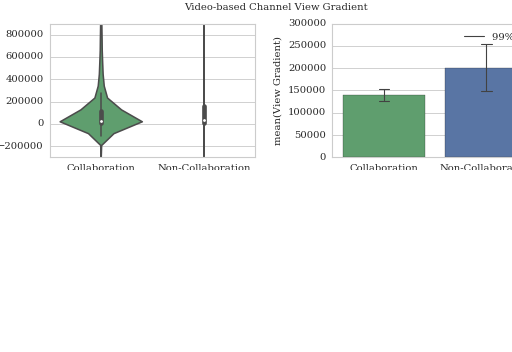

<IPython.core.display.Javascript object>


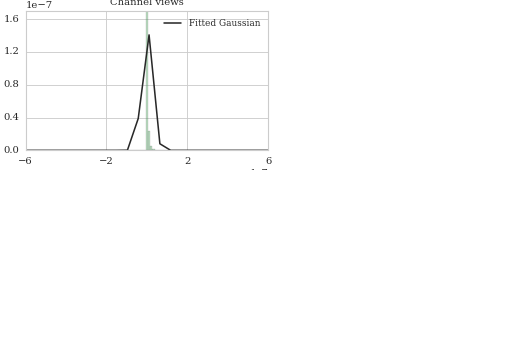

In [89]:
# Boxplot video-based viewcount gradient for all collab channel 


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="gradient", data=df_video_channel_viewcounts_collabs, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="gradient", data=df_video_channel_viewcounts_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Gradient')
ax2.set_ylabel('mean(View Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video-based Channel View Gradient')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-300000.0, 900000.0])
save_plot('collab_channel_video_based_view_box_ci_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs["gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['gradient'])

fig = plt.figure()
ax = sns.distplot(test['gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Channel views')
plt.tight_layout()
ax.set_ylim([0.0, 1.7e-7])
ax.set_xlim([-5e+7, 5e+7])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_channel_video_based_view_norm_fit.pdf', fig, s_width, s_height)

#print 'Normal-dist-test:', normaltest(test['gradient'])

collabs_grads = test[test.collab_window == 'Collab']['gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


<IPython.core.display.Javascript object>


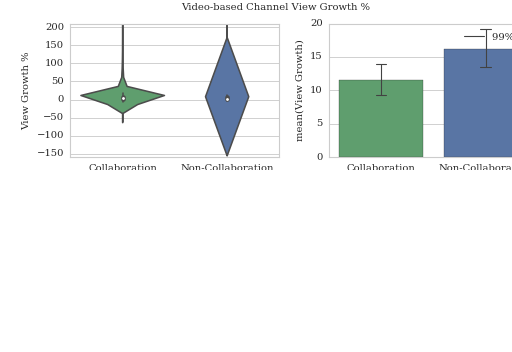

<IPython.core.display.Javascript object>


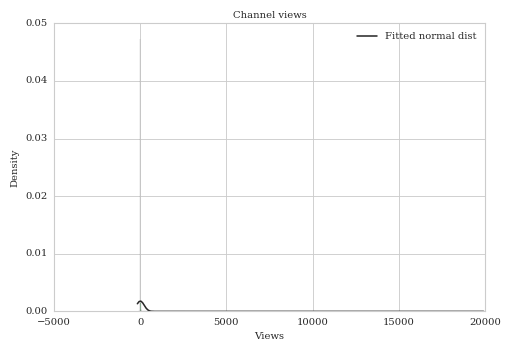

In [90]:
# Boxplot video-based viewcount percentage gradient for all collab channel 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_video_channel_viewcounts_collabs, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_video_channel_viewcounts_collabs, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Growth %')
ax2.set_ylabel('mean(View Growth)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video-based Channel View Growth %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-160.0, 210.0])
save_plot('collab_channel_video_based_view_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_video_channel_viewcounts_collabs[df_video_channel_viewcounts_collabs["p_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Channel views')
plt.tight_layout()

#print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


In [91]:
# new method
# do gradient day-wise, create 6 day plot with 6 double bars, collab, non_collab
# every bar is gradient of that day (the day x after collab)

# create dataframe accordingly

df_channel_history_collabs.head()

channelID    viewCount  subscriberCount  commentCount  \
id                                                                           
7956  UC-4kjzuh4822B9yPSgpZQgA   28931198.0          1238595             0   
7968  UC-63s9JLCZqIDlhXK6VHb7w    8835366.0            27605             0   
7970  UC-A4oZF4AlOEdlyZWBCI0cQ  337869772.0          1642804          3676   
7972  UC-aJ5-YxVUH77ro5MGJt7Dg   52265092.0           185099             0   
7983  UC-CRXGRabkMD7x6V_Nk9F0A     475640.0             2861             0   

      videoCount      crawlTimestamp  gradient  p_gradient collab_window  \
id                                                                         
7956          50 2016-12-29 00:00:03    4184.0    0.338947    Non_Collab   
7968          89 2016-12-29 00:00:03      -1.0   -0.003622           NaN   
7970         549 2016-12-29 00:00:04     185.0    0.011263           NaN   
7972         241 2016-12-29 00:00:04     835.0    0.453154    Non_Collab   
7983         193 2016-12-29 00:00:04       9.0    0.315568           NaN   

      viewCount_gradient  p_viewCount_gradient  
id                                              
7956            259972.0              0.906735  
7968              1195.0              0.013527  
7970            179243.0              0.053079  
7972            238951.0              0.459290  
7983               993.0              0.209208

In [92]:
# add information to dataframe which day after collab it is

df_channel_history_collabs_days = df_channel_history_collabs.copy()

channel_collabs_days_group = df_channel_history_collabs_days.groupby(['channelID'])

df_channel_history_collabs_days['collab_window'] = 'NaN'
df_channel_history_collabs_days['day_after'] = -1

for name, group in channel_collabs_days_group:
    collab_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]

    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])

    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=6))
    
    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=6))

    
    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
        if (df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_channel_history_collabs_days.ix[filtered.index, 'collab_window'] = 'Collab'
        # create new column day_after, with 0 to 6 day after collab value
        df_channel_history_collabs_days.ix[filtered.index, 'day_after']  = filtered['crawlTimestamp'].apply(lambda x: (x-date).days)
    

df_channel_history_collabs_days.head()

channelID    viewCount  subscriberCount  commentCount  \
id                                                                           
7956  UC-4kjzuh4822B9yPSgpZQgA   28931198.0          1238595             0   
7968  UC-63s9JLCZqIDlhXK6VHb7w    8835366.0            27605             0   
7970  UC-A4oZF4AlOEdlyZWBCI0cQ  337869772.0          1642804          3676   
7972  UC-aJ5-YxVUH77ro5MGJt7Dg   52265092.0           185099             0   
7983  UC-CRXGRabkMD7x6V_Nk9F0A     475640.0             2861             0   

      videoCount      crawlTimestamp  gradient  p_gradient collab_window  \
id                                                                         
7956          50 2016-12-29 00:00:03    4184.0    0.338947    Non_Collab   
7968          89 2016-12-29 00:00:03      -1.0   -0.003622           NaN   
7970         549 2016-12-29 00:00:04     185.0    0.011263           NaN   
7972         241 2016-12-29 00:00:04     835.0    0.453154    Non_Collab   
7983         193 2016-12-29 00:00:04       9.0    0.315568           NaN   

      viewCount_gradient  p_viewCount_gradient                     day_after  
id                                                                            
7956            259972.0              0.906735 1969-12-31 23:59:59.999999999  
7968              1195.0              0.013527 1969-12-31 23:59:59.999999999  
7970            179243.0              0.053079 1969-12-31 23:59:59.999999999  
7972            238951.0              0.459290 1969-12-31 23:59:59.999999999  
7983               993.0              0.209208 1969-12-31 23:59:59.999999999

In [97]:
#df_channel_history_collabs_days.head()

#df_channel_history_collabs_days.day_after = df_channel_history_collabs_days.day_after.astype(int)

#df_channel_history_collabs_days.p_gradient.describe()

In [98]:
df_channel_history_collabs_days[df_channel_history_collabs_days.p_gradient > 30]

#df_channel_history_collabs_days_cop = df_channel_history_collabs_days[df_channel_history_collabs_days.p_gradient < 1000]

channelID     viewCount  subscriberCount  commentCount  \
id                                                                              
52314   UCmuBqEMBGe1SKWlF33JUz0w  1.750000e+03             3973             0   
96981   UCAV6zGvyXIte0HTqExfzxVA  2.258583e+07            84799             0   
198389  UCZ30pt71ahOkpINeSSGfC7Q  1.688187e+04              255            10   
444845  UC3FZmaEFoeMneQa1fubP74g  2.979300e+04             3468             0   
452762  UC3FZmaEFoeMneQa1fubP74g  2.983800e+04             4639             0   
531370  UC_n9YEcHMarYJShR-e1V9Xg  4.344750e+05             3166             0   
789501  UCpeJ5_1dzVxAPMehXCXL19A  1.024499e+06            34927             0   
791384  UCx0x2_DpGMO0mSQwWPFSwCw  4.105955e+06            43128             0   
793883  UCbAg65u3LLHe2PU8AXx6Vfw  1.650686e+07           115648            40   

        videoCount      crawlTimestamp  gradient  p_gradient collab_window  \
id                                                                           
52314           19 2017-01-03 00:03:38    1491.0   60.072522    Non_Collab   
96981           75 2017-01-09 00:01:33   24468.0   40.556265    Non_Collab   
198389           9 2017-01-20 00:07:34      60.0   30.769231        Collab   
444845          34 2017-02-21 00:00:38     942.0   37.292162    Non_Collab   
452762          34 2017-02-22 00:00:39    1171.0   33.765859    Non_Collab   
531370          36 2017-03-04 00:00:07     759.0   31.533029        Collab   
789501          77 2017-04-05 00:05:56    9925.0   39.696824           NaN   
791384         279 2017-04-05 00:08:00   11835.0   37.819960    Non_Collab   
793883         180 2017-04-06 00:02:11   28317.0   32.424912    Non_Collab   

        viewCount_gradient  p_viewCount_gradient  day_after  
id                                                           
52314            40.000000              2.339181         -1  
96981         39756.000000              0.176332         -1  
198389           88.228057              0.525366          2  
444845           26.000000              0.087345         -1  
452762           45.000000              0.151042         -1  
531370         4715.000000              1.097124          0  
789501         2393.000000              0.234124         -1  
791384         6521.000000              0.159071         -1  
793883        10866.000000              0.065871         -1

<IPython.core.display.Javascript object>


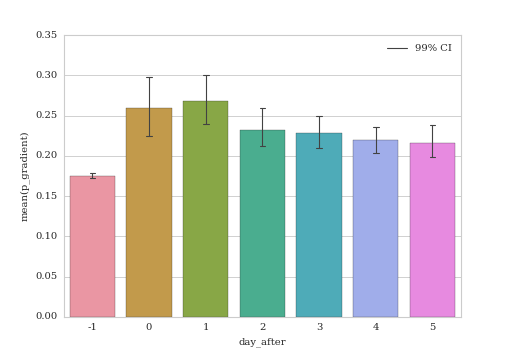

In [99]:
fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1)
plt.legend(["{}% CI".format(99)])

<IPython.core.display.Javascript object>


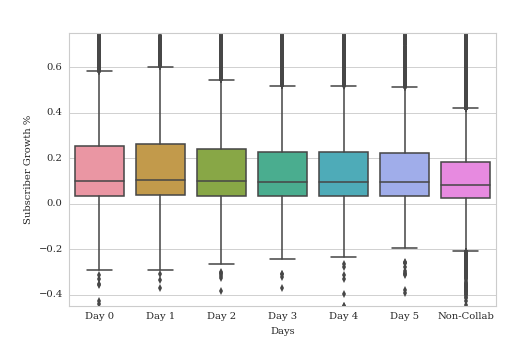

<IPython.core.display.Javascript object>


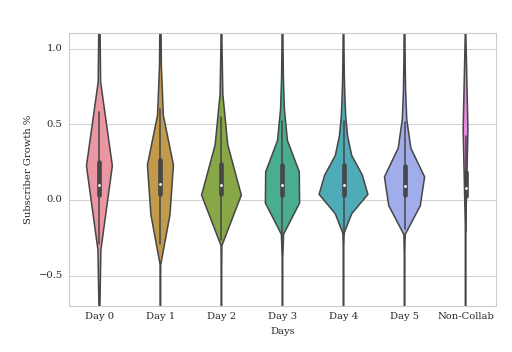

<IPython.core.display.Javascript object>


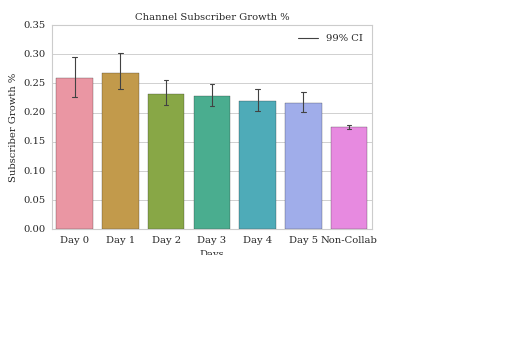

<IPython.core.display.Javascript object>


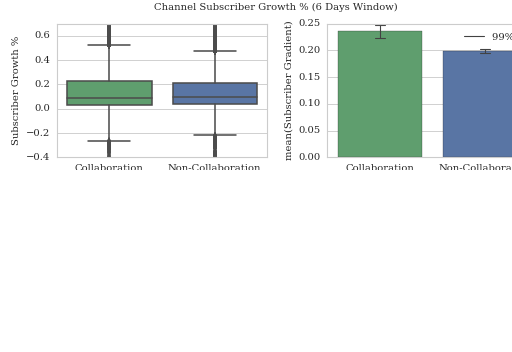

<IPython.core.display.Javascript object>


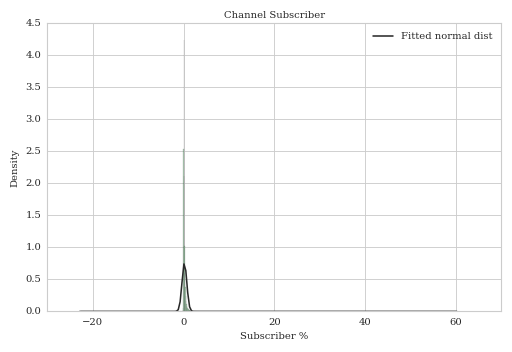

In [100]:
fig = plt.figure()
ax = sns.boxplot(x=df_channel_history_collabs_days["day_after"], y=df_channel_history_collabs_days["p_gradient"], order=[0, 1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Subscriber Growth %')
ax.set_ylim([-0.45, 0.75])
#plt.title('Channel Subscriber Growth %')
save_plot('collab_channel_6days_subscriber_box_perc.pdf', fig, x_width, x_height)

fig = plt.figure()
ax = sns.violinplot(x=df_channel_history_collabs_days["day_after"], y=df_channel_history_collabs_days["p_gradient"], order=[0, 1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Subscriber Growth %')
ax.set_ylim([-0.7, 1.1])
#plt.title('Channel Subscriber Growth %')
save_plot('collab_channel_6days_subscriber_box_perc_violin.pdf', fig, x_width, x_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, order=[0, 1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax1.set_xlabel('Days')
ax1.set_ylabel('Subscriber Growth %')
plt.legend(["{}% CI".format(99)])
plt.title('Channel Subscriber Growth %')
save_plot('collab_channel_6days_subscriber_ci_perc_s.pdf', fig, 1.5*s_width, 1.5*s_height)


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs_days, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Subscriber Growth %')
ax2.set_ylabel('mean(Subscriber Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel Subscriber Growth % (6 Days Window)')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-0.4, 0.7])
save_plot('collab_channel_6days_subscriber_box_ci_perc.pdf', fig, 2*s_width, s_height)

#print 'Non_Collabs:'
#print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Non_Collab']['p_gradient'].describe()
#print '\nCollabs:'
#print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Collab']['p_gradient'].describe()

test = df_channel_history_collabs_days
# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber %')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
plt.tight_layout()

#print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

<IPython.core.display.Javascript object>


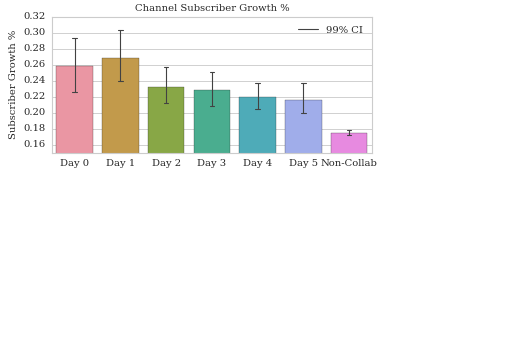

In [186]:
fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, order=[0, 1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax1.set_xlabel('Days')
ax1.set_ylabel('Subscriber Growth %')
plt.legend(["{}% CI".format(99)])
plt.title('Channel Subscriber Growth %')
ax1.set_ylim([0.15, 0.32])
save_plot('collab_channel_6days_subscriber_ci_perc_s.pdf', fig, 1.5*s_width, s_height)

In [101]:
# Boxplot viewCount gradient for collab channel (only channel with collabs)

print 'Non_Collabs:'
print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Non_Collab']['p_viewCount_gradient'].describe()
print '\nCollabs:'
print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Collab']['p_viewCount_gradient'].describe()


#df_channel_history_collabs_days_cop.head()

Non_Collabs:
count    109686.000000
mean          0.263285
std           1.062748
min         -92.000145
25%           0.070633
50%           0.146861
75%           0.301703
max          65.802956
Name: p_viewCount_gradient, dtype: float64

Collabs:
count    20953.000000
mean         0.324559
std          1.405709
min        -79.616772
25%          0.056532
50%          0.131636
75%          0.316360
max         72.233197
Name: p_viewCount_gradient, dtype: float64


<IPython.core.display.Javascript object>


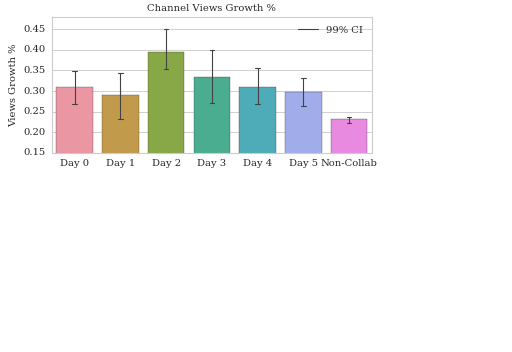

In [187]:
fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_viewCount_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, order=[0, 1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('Days')
ax1.set_ylabel('Views Growth %')
plt.title('Channel Views Growth %')
ax1.set_ylim([0.15, 0.48])
save_plot('collab_channel_6days_views_ci_perc_s.pdf', fig, 1.5*s_width, s_height)

<IPython.core.display.Javascript object>


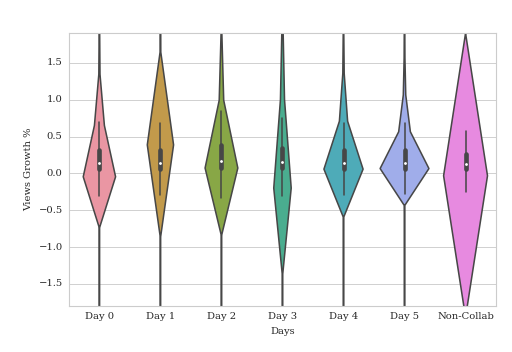

<IPython.core.display.Javascript object>


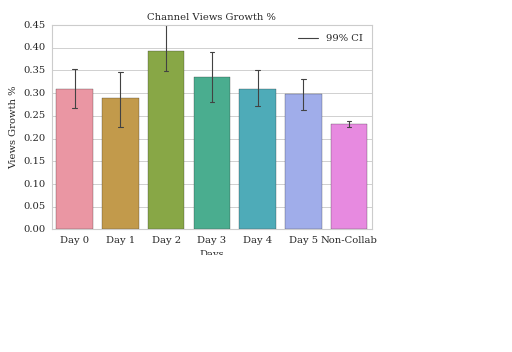

<IPython.core.display.Javascript object>


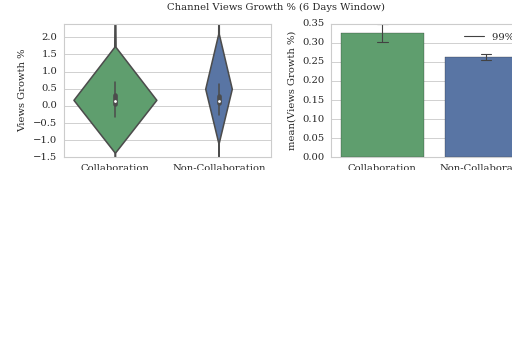

<IPython.core.display.Javascript object>


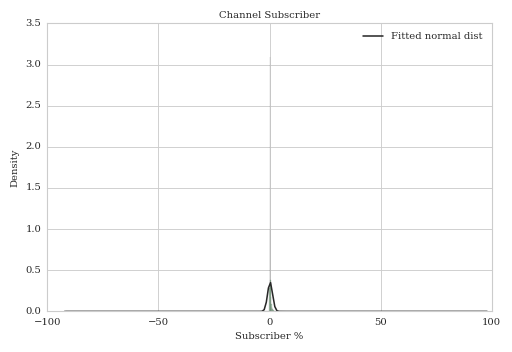

In [102]:
fig = plt.figure()
ax = sns.violinplot(x=df_channel_history_collabs_days["day_after"], y=df_channel_history_collabs_days["p_viewCount_gradient"], order=[0, 1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views Growth %')
ax.set_ylim([-1.8, 1.9])
save_plot('collab_channel_6days_views_box_perc_violin.pdf', fig, x_width, x_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_viewCount_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, order=[0, 1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('Days')
ax1.set_ylabel('Views Growth %')
plt.title('Channel Views Growth %')
save_plot('collab_channel_6days_views_ci_perc_s.pdf', fig, 1.5*s_width, 1.5*s_height)


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_viewCount_gradient", data=df_channel_history_collabs_days, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_viewCount_gradient", data=df_channel_history_collabs_days, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views Growth %')
ax2.set_ylabel('mean(Views Growth %)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Channel Views Growth % (6 Days Window)')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-1.5, 2.4])
save_plot('collab_channel_6days_views_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

#print 'Non_Collabs:'
#print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Non_Collab']['p_viewCount_gradient'].describe()
#print '\nCollabs:'
#print df_channel_history_collabs_days[df_channel_history_collabs_days.collab_window=='Collab']['p_viewCount_gradient'].describe()

test = df_channel_history_collabs_days
# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_viewCount_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_viewCount_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber %')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
plt.tight_layout()

#print 'Normal-dist-test:', normaltest(test['p_viewCount_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_viewCount_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_viewCount_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

In [115]:
# same as above with video based viewcounts too


df_video_channel_viewcounts_collabs_days = df_video_channel_viewcounts_collabs.copy()

video_channel_view_groups = df_video_channel_viewcounts_collabs_days.groupby(['channelID'])


df_video_channel_viewcounts_collabs_days['collab_window'] = 'NaN'
df_video_channel_viewcounts_collabs_days['day_after'] = -1

cnt=0

for name, group in video_channel_view_groups:
    
    if len(group['viewCount']) < 2:
        cnt += 1
        continue
    
    collab_videos = []
    with db._session_scope(False) as session:
        # own videos
        for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )


        # external videos (hes in)
        for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
            #print row.videos
            for vid in row['videos']:
                date = session.query(Video.dateAdded).filter(Video.id==vid).first()[0]
                collab_videos.append( (vid, date) )
        all_videos = session.query(Video.id, Video.dateAdded).filter(Video.channelID==name).all()
        norm_videos = [x for x in all_videos if x not in collab_videos]

    df_group_videos = pa.DataFrame(collab_videos, columns=['video', 'date'])
    df_group_norm_videos = pa.DataFrame(norm_videos, columns=['video', 'date'])

    df_group_videos['date'] = df_group_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_videos['date_plus'] = df_group_videos['date'].apply(lambda x: x+timedelta(days=6))
    
    df_group_norm_videos['date'] = df_group_norm_videos['date'].apply(lambda x: datetime.strptime(x, date_format))
    df_group_norm_videos['date_plus'] = df_group_norm_videos['date'].apply(lambda x: x+timedelta(days=6))

        
    for index, row in df_group_norm_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['date'] > date.date()) & (group['date'] < date_plus.date())]
        df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'collab_window'] = 'Non_Collab'

    for index, row in df_group_videos.iterrows():
        date, date_plus = row['date'], row['date_plus']
        filtered = group[(group['date'] > date.date()) & (group['date'] < date_plus.date())]
        if (df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'collab_window'] == 'Non_Collab').all():
            df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'collab_window'] = 'NaN'
        else:
            df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'collab_window'] = 'Collab'
        # create new column day_after, with 0 to 6 day after collab value
        df_video_channel_viewcounts_collabs_days.ix[filtered.index, 'day_after']  = filtered['date'].apply(lambda x: (x-date.date()).days)
    
        
        
        
print cnt

print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Collab']['gradient'].describe()

print 'Non_Collabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Collab']['p_gradient'].describe()


0
Non_Collabs:
count    1.028940e+05
mean     1.217206e+05
std      3.405675e+06
min     -5.176074e+08
25%      3.266250e+03
50%      1.890650e+04
75%      8.139300e+04
max      5.466151e+08
Name: gradient, dtype: float64

Collabs:
count    1.717200e+04
mean     1.336891e+05
std      3.705492e+05
min     -7.627410e+05
25%      2.792250e+03
50%      2.070600e+04
75%      9.416875e+04
max      1.165972e+07
Name: gradient, dtype: float64
Non_Collabs:
count    102894.000000
mean         16.542272
std         264.929855
min         -99.960278
25%           1.148584
50%           2.181452
75%           4.972661
max       19855.358189
Name: p_gradient, dtype: float64

Collabs:
count    17172.000000
mean        11.815643
std        163.294501
min        -41.646873
25%          1.368504
50%          2.789609
75%          6.591373
max      17940.000000
Name: p_gradient, dtype: float64


In [116]:
df_video_channel_viewcounts_collabs_days.head()

channelID        date  viewCount  gradient  p_gradient  \
705  UC-4kjzuh4822B9yPSgpZQgA  2016-12-30     115837   68301.0  143.682683   
706  UC-4kjzuh4822B9yPSgpZQgA  2016-12-31     143568   27731.0   23.939674   
707  UC-4kjzuh4822B9yPSgpZQgA  2017-01-01     162885   19317.0   13.454948   
708  UC-4kjzuh4822B9yPSgpZQgA  2017-01-02     203065   40180.0   24.667710   
709  UC-4kjzuh4822B9yPSgpZQgA  2017-01-03     345925  142860.0   70.351858   

    collab_window  day_after  
705    Non_Collab         -1  
706    Non_Collab         -1  
707    Non_Collab         -1  
708    Non_Collab         -1  
709    Non_Collab         -1

In [117]:
len(df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.p_gradient > 1000])

#df_video_channel_viewcounts_collabs_days = df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.p_gradient < 10000]

#df_video_channel_viewcounts_collabs_days.day_after

281

<IPython.core.display.Javascript object>


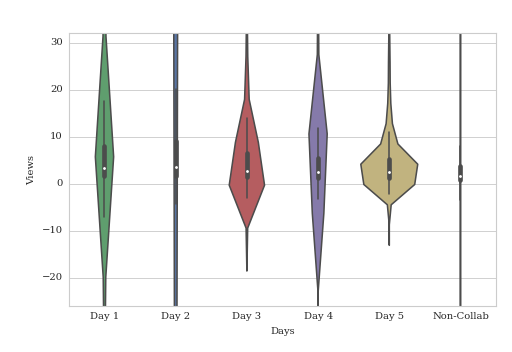

<IPython.core.display.Javascript object>


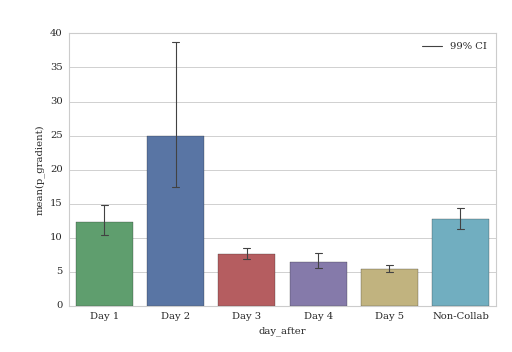

<IPython.core.display.Javascript object>


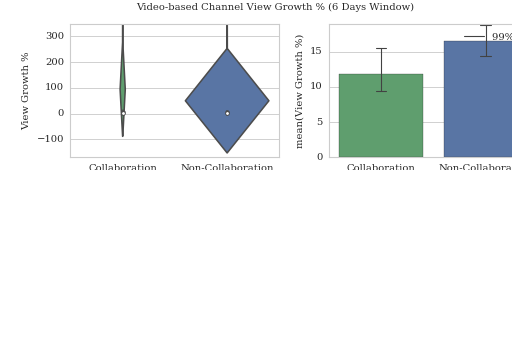

<IPython.core.display.Javascript object>


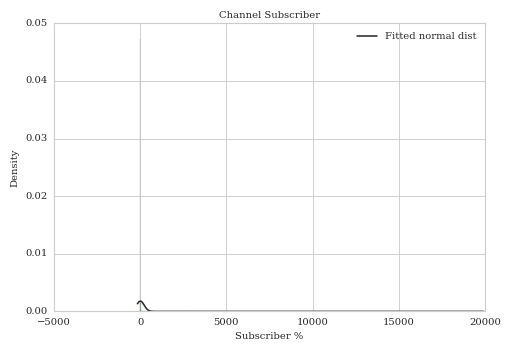

In [118]:

fig = plt.figure()
ax = sns.violinplot(x=df_video_channel_viewcounts_collabs_days["day_after"], y=df_video_channel_viewcounts_collabs_days["p_gradient"], order=[1, 2, 3, 4, 5, -1])
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
ax.set_ylim([-26.0, 32.0])
save_plot('collab_channel_6days_video-based-views_box_perc_violin.pdf', fig, x_width, x_height)

fig = plt.figure()
ax1 = sns.barplot(x="day_after", y="p_gradient", data=df_video_channel_viewcounts_collabs_days, ci=99, errwidth=1., capsize=.1, order=[1, 2, 3, 4, 5, -1])
ax1.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Non-Collab'])
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('Days')
ax.set_ylabel('Views')
save_plot('collab_channel_6days_video-based-views_ci_perc.pdf', fig, x_width, x_height)

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(x="collab_window", y="p_gradient", data=df_video_channel_viewcounts_collabs_days, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_video_channel_viewcounts_collabs_days, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('View Growth %')
ax2.set_ylabel('mean(View Growth %)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video-based Channel View Growth % (6 Days Window)')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-170.0, 350.0])
ax2.set_ylim([0.0, 19.0])
save_plot('collab_channel_6days_video-based-views_box_ci_perc_violin.pdf', fig, 2*s_width, s_height)

#print 'Non_Collabs:'
#print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Non_Collab']['p_gradient'].describe()
#print '\nCollabs:'
#print df_video_channel_viewcounts_collabs_days[df_video_channel_viewcounts_collabs_days.collab_window=='Collab']['p_gradient'].describe()

test = df_video_channel_viewcounts_collabs_days
# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Subscriber %')
ax.set_ylabel('Density')
plt.title('Channel Subscriber')
plt.tight_layout()

#print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

#print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
#print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

In [ ]:
# Effect of repeated collaborations

# get channel pairs with > 30 collabs
# for both channel print metrics comparable over timeframe, with lines for collabs
# metrics subscriber, view-count, ?
# both as normal values and percentage growth


# TODO
# problem is in this data, the collabs with other pairs is in it too
# filter all other collabs out?

# instead of collabs between only single pair of 4-2 classes, get all pairs for more data

In [103]:
# group filtered collabs into popularity pairs?
# this would more fit the task Wie profitieren unterschiedliche Popularitätsklassen von Kollaborationen?

df_collab_popularity_groups = df_graph_filtered.groupby(by=['from_popularity', 'to_popularity'])

print(len(df_collab_popularity_groups))

df_collab_category_groups = df_graph_filtered.groupby(by=['from_category', 'to_category'])

print(len(df_collab_category_groups))

df_collab_popularity_groups = df_collab_popularity_groups.filter(lambda x: len(x) > 30).groupby(by=['from_popularity', 'to_popularity'])
print(len(df_collab_popularity_groups))

df_collab_category_groups = df_collab_category_groups.filter(lambda x: len(x) > 30).groupby(by=['from_category', 'to_category'])
print(len(df_collab_category_groups))

36
131
11
16


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


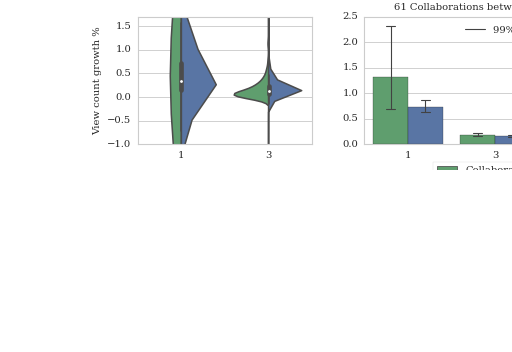

<IPython.core.display.Javascript object>


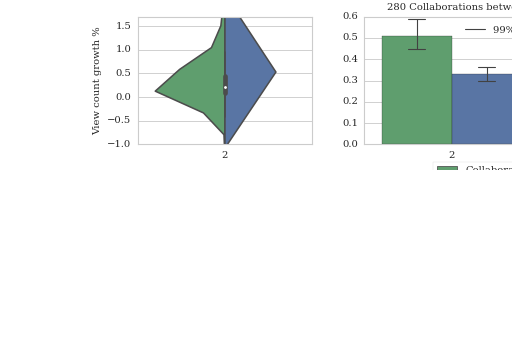

<IPython.core.display.Javascript object>


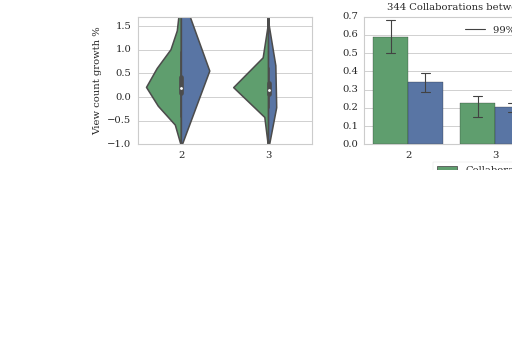

<IPython.core.display.Javascript object>


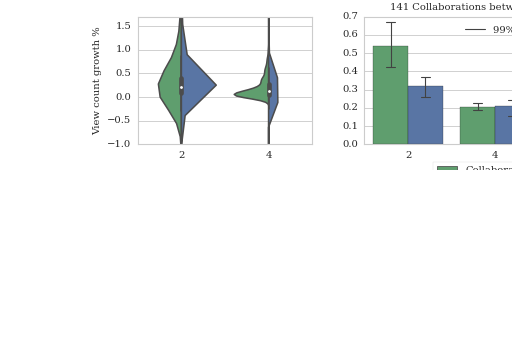

<IPython.core.display.Javascript object>


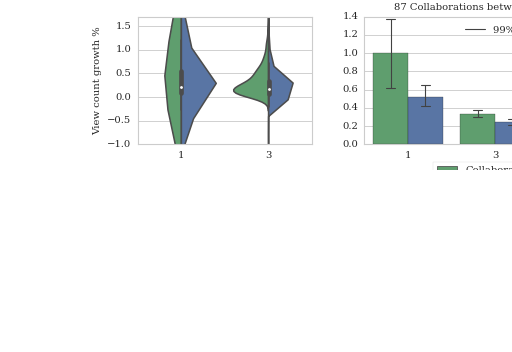

<IPython.core.display.Javascript object>


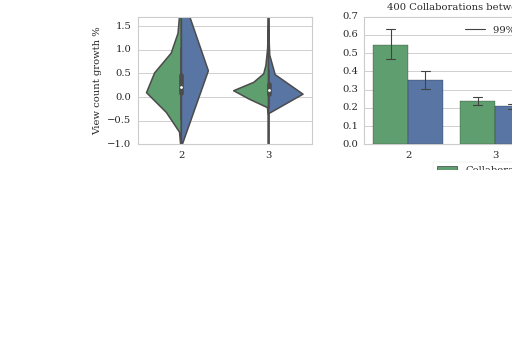

<IPython.core.display.Javascript object>


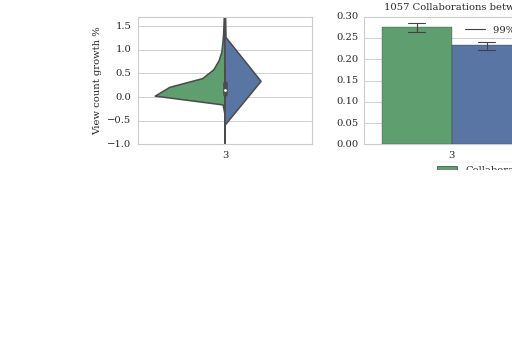

<IPython.core.display.Javascript object>


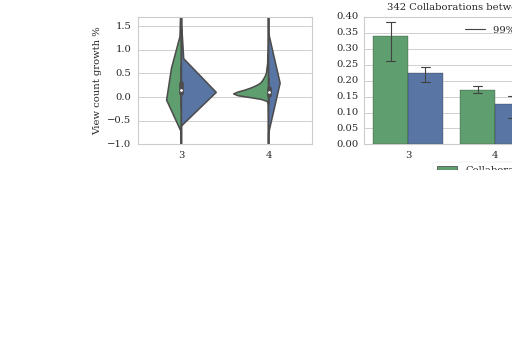

<IPython.core.display.Javascript object>


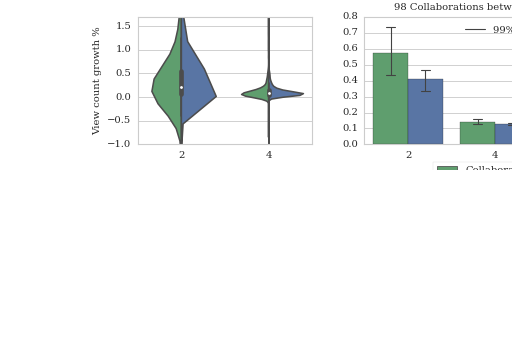

<IPython.core.display.Javascript object>


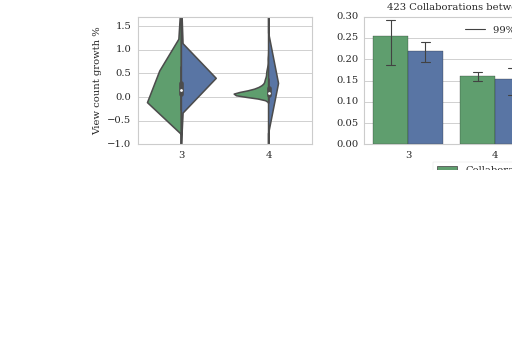

<IPython.core.display.Javascript object>


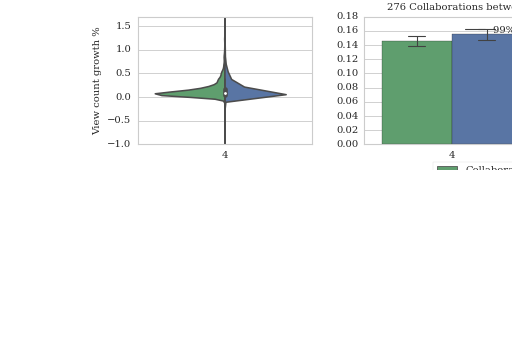

In [132]:
# Effekt von wiederholten kollaborationen? task
# For channel with the most collabs, and different popularities

pdf = matplotlib.backends.backend_pdf.PdfPages(CDIR+'/'+'collab_channel_popularity_combined.pdf')


for name, group in df_collab_popularity_groups:

    pop_group = group

    _num_channel = len(pop_group)

    _from_mask = pop_group['from']

    _from_popularity = group['from_popularity'].iloc[0]

    _to_mask = pop_group['to']

    _to_popularity = group['to_popularity'].iloc[0]

    _weights = pop_group['weight'].sum()

    from_group = df_channel_history_collabs_days[df_channel_history_collabs_days['channelID'].isin(_from_mask)]
    from_group['popularity'] = _from_popularity
    to_group = df_channel_history_collabs_days[df_channel_history_collabs_days['channelID'].isin(_to_mask)]
    to_group['popularity'] = _to_popularity

    test = pa.concat([to_group, from_group])
    test = test[(test.collab_window=='Collab') | (test.collab_window=='Non_Collab')]

    #fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True)
    fig = plt.figure()

    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    sns.violinplot(x="popularity", y="p_viewCount_gradient", hue='collab_window', data=test, ax=ax1, split=True, hue_order=['Collab', 'Non_Collab'])
    sns.barplot(x="popularity", y="p_viewCount_gradient", hue='collab_window', data=test, ci=99, errwidth=1., capsize=.1, ax=ax2, hue_order=['Collab', 'Non_Collab'])
    ax2.legend(["{}% CI".format(99)])
    ax1.set_xlabel('')
    ax1.set_ylabel('View count growth %')
    ax2.set_ylabel('')
    ax1.legend_.remove()
    #ax2.legend_.remove()

    ax3 = fig.add_subplot(143, sharey=ax1)
    ax4 = fig.add_subplot(144, sharey=ax2)
    #fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.violinplot(x="popularity", y="p_gradient", hue='collab_window', data=test, ax=ax3, split=True, hue_order=['Collab', 'Non_Collab'])
    sns.barplot(x="popularity", y="p_gradient", hue='collab_window', data=test, ci=99, errwidth=1., capsize=.1, ax=ax4, hue_order=['Collab', 'Non_Collab'])
    ax4.legend(["{}% CI".format(99)])
    ax3.set_xlabel('')
    ax3.set_ylabel('Subscriber growth %')
    ax4.set_xlabel('')
    ax4.set_ylabel('')
    #ax4.legend_.remove()
    fig.suptitle('{} Collaborations between {} channels from popularity {} to {}'.format(_weights, _num_channel, _from_popularity, _to_popularity))
    #fig.tight_layout()
    ax1.set_ylim([-1.0, 1.7])
    ax2.set_xlabel('Popularity', position=(1.1,0.1))

    L = ax3.legend(frameon=True,loc='upper center', bbox_to_anchor=(-0.2, -0.1), ncol=2)
    L.get_texts()[0].set_text('Collaboration')
    L.get_texts()[1].set_text('Non-Collaboration')
    fig.subplots_adjust(top=0.8)
    fig.subplots_adjust(bottom=0.15, top=0.9, wspace=0.3)
    save_plot('collab_channel_popularity_{}_{}.pdf'.format(_from_popularity, _to_popularity), fig, 4*s_width, s_height)

    pdf.savefig(fig, bbox_inches="tight")
    
pdf.close()

In [127]:
# Effekt von wiederholten kollaborationen? task
# For channel with the most collabs, and different popularities

df_channe_history_collabs_days_combined = pa.DataFrame()

print(len(df_channel_history_collabs_days))

for name, group in list(df_collab_popularity_groups):

    pop_group = group

    _from_mask = pop_group['from']

    _from_popularity = group['from_popularity'].iloc[0]

    _to_mask = pop_group['to']

    _to_popularity = group['to_popularity'].iloc[0]


    from_group = df_channel_history_collabs_days[df_channel_history_collabs_days['channelID'].isin(_from_mask)]
    from_group['popularity'] = '{} ({} in {})'.format(_from_popularity, _from_popularity, _to_popularity)
    to_group = df_channel_history_collabs_days[df_channel_history_collabs_days['channelID'].isin(_to_mask)]
    to_group['popularity'] = '{} ({} in {})'.format(_to_popularity, _from_popularity, _to_popularity)

    test = pa.concat([to_group, from_group])
    test = test[(test.collab_window=='Collab') | (test.collab_window=='Non_Collab')]

    df_channe_history_collabs_days_combined = df_channe_history_collabs_days_combined.append(test,ignore_index=True)
    

print(len(df_channe_history_collabs_days_combined))

189710


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


211107


<IPython.core.display.Javascript object>


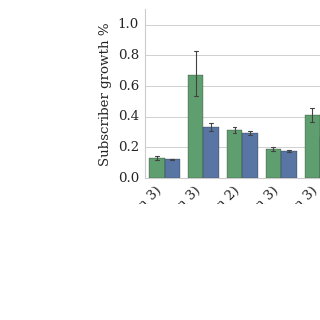

In [203]:
#df_channe_history_collabs_days_combined.head()
g = sns.factorplot(x="popularity", y="p_gradient", hue="collab_window", data=df_channe_history_collabs_days_combined, kind="bar", hue_order=['Collab', 'Non_Collab'], legend=False, ci=95, errwidth=1., capsize=.1)
L = g.axes[0][0].legend()
L.get_texts()[0].set_text('Collaboration')
L.get_texts()[1].set_text('Non-Collaboration')
g.set_ylabels('Subscriber growth %', fontsize=12)
#g.set_xlabels('Popularity Collaboration', fontsize=40)
g.set_xticklabels(rotation=45)
g.axes[0][0].set_ylim([0.0, 1.1])
plt.setp(g.axes[0][0].xaxis.get_majorticklabels(), ha='right')
g.axes[0][0].xaxis.label.set_visible(False)

for tick in g.axes[0][0].yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in g.axes[0][0].xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
import matplotlib.lines as mlines

handles, labels = g.axes[0][0].get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='k', marker='_',markersize=15, label="{}% CI".format(95)))
g.axes[0][0].legend(handles=handles, labels=['Collaboration', 'Non-Collaboration', '{}% CI'.format(95)], prop={'size': 12})
fig = g.fig
save_plot('collab_channel_popularity_combined_single_subscriber_s.pdf', fig, 3.5*s_width, 1.2*s_height)

<IPython.core.display.Javascript object>


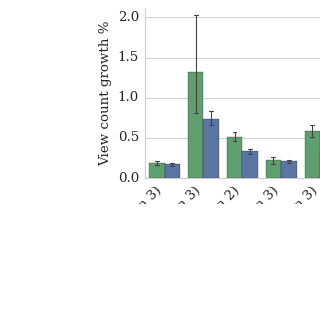

3
[u'Collab', u'Non_Collab']


In [201]:
#print(df_channe_history_collabs_days_combined.head())
g = sns.factorplot(x="popularity", y="p_viewCount_gradient", hue="collab_window", data=df_channe_history_collabs_days_combined, kind="bar", hue_order=['Collab', 'Non_Collab'], legend=False, ci=95, errwidth=1., capsize=.1)
#plt.legend(["{}% CI".format(99)])
L = g.axes[0][0].legend()
L.get_texts()[0].set_text('Collaboration')
L.get_texts()[1].set_text('Non-Collaboration')
g.set_ylabels('View count growth %', fontsize=12)
#g.set_xlabels('Popularity Collaboration')
g.set_xticklabels(rotation=45)
g.axes[0][0].set_ylim([0.0, 2.1])
plt.setp(g.axes[0][0].xaxis.get_majorticklabels(), ha='right')
g.axes[0][0].xaxis.label.set_visible(False)

for tick in g.axes[0][0].yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in g.axes[0][0].xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

import matplotlib.lines as mlines

handles, labels = g.axes[0][0].get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='k', marker='_',markersize=15, label="{}% CI".format(95)))
print(len(handles))
print(labels)
g.axes[0][0].legend(handles=handles, labels=['Collaboration', 'Non-Collaboration', '{}% CI'.format(95)], prop={'size': 12})
fig = g.fig
save_plot('collab_channel_popularity_combined_single_viewcount_s.pdf', fig, 3.5*s_width, 1.2*s_height)

In [166]:
# Effekt von wiederholten kollaborationen? task
# For channel with the most collabs, and different categories
'''
1	Film & Animation
2	Cars & Vehicles
10	Music
15	Pets & Animals
17	Sports
19	Travel & Events
20	Gaming
22	People & Blogs
23	Comedy
24	Entertainment
25	News & Politics
26	How-to & Style
27	Education
28	Science & Technology
29	Non-profits & Activism
'''

def shorter(x):
    try:
        return {'Film & Animation': 'Film',
               'Cars & Vehicles': 'Cars',
               'Pets & Animals': 'Animals',
               'Travel & Events': 'Travel',
               'People & Blogs': 'People',
               'Entertainment': 'Entert.',
               'Education': 'Educ.',
               'News & Politics': 'News',
               'How-to & Style': 'How-to',
               'Science & Technology': 'Science',
               'Non-profits & Activism': 'Non-profits'}[x]
    except:
        return x

def filt(curr, _from, to):
    
    if curr=='Comedy':
        if _from=='Comedy':
            if to=='Entertainment':
                return False

    elif curr=='Gaming':
        if _from=='Comedy':
            if to=='Gaming':
                return False
        elif _from=='Entertainment':
            if to=='Gaming':
                return False
        elif _from=='People & Blogs':
            if to=='Gaming':
                return False
        
    elif curr=='Entertainment':
        if _from=='Entertainment':
            if to=='Gaming':
                return False
        if _from=='Entertainment':
            if to=='People & Blogs':
                return False
            
    elif curr=='People & Blogs':
        if _from=='Entertainment':
            if to=='People & Blogs':
                return False
        if _from=='How-to & Style':
            if to=='People & Blogs':
                return False
        if _from=='People & Blogs':
            if to=='How-to & Style':
                return False
        if _from=='People & Blogs':
            if to=='Gaming':
                return False
            
    elif curr=='How-to & Style':
        if _from=='How-to & Style':
            if to=='People & Blogs':
                return False
        if _from=='People & Blogs':
            if to=='How-to & Style':
                return False
    else:
        return True
    
    return True
    


df_channe_history_collabs_days_combined_category = pa.DataFrame()

print(len(df_channel_history_collabs_days))

for name, group in list(df_collab_category_groups):

    pop_group = group

    _from_mask = pop_group['from']

    _from_popularity = group['from_category'].iloc[0]
    
    _to_mask = pop_group['to']

    _to_popularity = group['to_category'].iloc[0]
    
        
    if not filt(_from_popularity, _from_popularity, _to_popularity):
        if not filt(_to_popularity, _from_popularity, _to_popularity):
            continue
    
    if not filt(_from_popularity, _from_popularity, _to_popularity):
        to_group = df_channel_history_collabs_days[df_channel_history_collabs_days['channelID'].isin(_to_mask)]
        to_group['category'] = '{} ({} in {})'.format(shorter(_to_popularity), shorter(_from_popularity), shorter(_to_popularity))

        test = to_group[(to_group.collab_window=='Collab') | (to_group.collab_window=='Non_Collab')]
        
    elif not filt(_to_popularity, _from_popularity, _to_popularity):
        from_group = df_channel_history_collabs_days[df_channel_history_collabs_days['channelID'].isin(_from_mask)]
        from_group['category'] = '{} ({} in {})'.format(shorter(_from_popularity), shorter(_from_popularity), shorter(_to_popularity))

        test = from_group[(from_group.collab_window=='Collab') | (from_group.collab_window=='Non_Collab')]
        
    else:
        from_group = df_channel_history_collabs_days[df_channel_history_collabs_days['channelID'].isin(_from_mask)]
        from_group['category'] = '{} ({} in {})'.format(shorter(_from_popularity), shorter(_from_popularity), shorter(_to_popularity))
        to_group = df_channel_history_collabs_days[df_channel_history_collabs_days['channelID'].isin(_to_mask)]
        to_group['category'] = '{} ({} in {})'.format(shorter(_to_popularity), shorter(_from_popularity), shorter(_to_popularity))

        test = pa.concat([to_group, from_group])
        test = test[(test.collab_window=='Collab') | (test.collab_window=='Non_Collab')]

        
    df_channe_history_collabs_days_combined_category = df_channe_history_collabs_days_combined_category.append(test,ignore_index=True)


print(len(df_channe_history_collabs_days_combined_category))

189710


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

123616


In [167]:
print(df_channe_history_collabs_days_combined_category.category.unique())

['Comedy (Comedy in Comedy)' 'Entert. (Comedy in Entert.)'
 'People (Comedy in People)' 'Comedy (Comedy in People)'
 'Entert. (Educ. in Entert.)' 'Educ. (Educ. in Entert.)'
 'Comedy (Entert. in Comedy)' 'Entert. (Entert. in Comedy)'
 'Entert. (Entert. in Entert.)' 'Film (Entert. in Film)'
 'Entert. (Entert. in Film)' 'Entert. (Film in Entert.)'
 'Film (Film in Entert.)' 'Entert. (How-to in Entert.)'
 'How-to (How-to in Entert.)' 'How-to (How-to in How-to)'
 'Comedy (People in Comedy)' 'People (People in Comedy)'
 'Entert. (People in Entert.)' 'People (People in Entert.)'
 'People (People in People)']


In [173]:
def bolder(x):
    try:
        return {'Comedy (Comedy in Comedy)': 'Comedy',
               'Entert. (Entert. in Entert.)': 'Entert.',
               'How-to (How-to in How-to)': 'How-to',
               'People (People in People)': 'People'}[x]
    except:
        return x

<IPython.core.display.Javascript object>


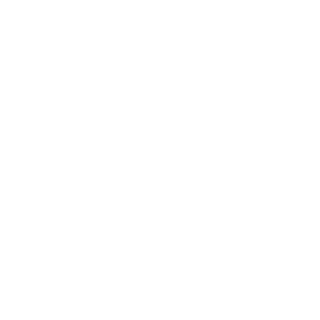

3
[u'Collab', u'Non_Collab']


In [200]:
#from matplotlib import rc,rcParams

# activate latex text rendering
#rc('text', usetex=False)


#df_channe_history_collabs_days_combined.head()
g = sns.factorplot(x="category", y="p_gradient", hue="collab_window", data=df_channe_history_collabs_days_combined_category, kind="bar", hue_order=['Collab', 'Non_Collab'], legend=False, ci=95, errwidth=1., capsize=.1)
#plt.legend(["{}% CI".format(99)])
L = g.axes[0][0].legend()
L.get_texts()[0].set_text('Collaboration')
L.get_texts()[1].set_text('Non-Collaboration')
g.set_ylabels('Subscriber growth %', fontsize=13)
#g.set_xlabels('Category Collaboration')
g.set_xticklabels(rotation=45)
plt.setp(g.axes[0][0].xaxis.get_majorticklabels(), ha='right')
g.axes[0][0].xaxis.label.set_visible(False)

for tick in g.axes[0][0].yaxis.get_major_ticks():
    tick.label.set_fontsize(13) 

for tick in g.axes[0][0].xaxis.get_major_ticks():
    tick.label.set_fontsize(13) 

labels = [bolder(item.get_text()) for item in g.axes[0][0].get_xticklabels()]

g.axes[0][0].set_xticklabels(labels)    
    
import matplotlib.lines as mlines

handles, labels = g.axes[0][0].get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='k', marker='_',markersize=15, label="{}% CI".format(95)))
print(len(handles))
print(labels)
g.axes[0][0].legend(handles=handles, labels=['Collaboration', 'Non-Collaboration', '{}% CI'.format(95)], prop={'size': 13})
fig = g.fig
save_plot('collab_channel_category_combined_single_subscriber_s.pdf', fig, 6*s_width, 1.5*s_height)

<IPython.core.display.Javascript object>


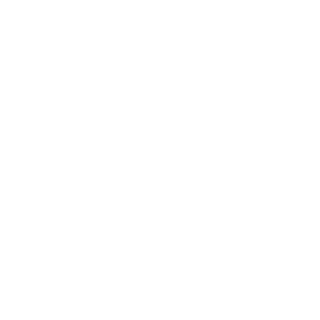

3
[u'Collab', u'Non_Collab']


In [204]:
#df_channe_history_collabs_days_combined.head()
g = sns.factorplot(x="category", y="p_viewCount_gradient", hue="collab_window", data=df_channe_history_collabs_days_combined_category, kind="bar", hue_order=['Collab', 'Non_Collab'], legend=False, ci=95, errwidth=1., capsize=.1)
#plt.legend(["{}% CI".format(99)])
L = g.axes[0][0].legend()
L.get_texts()[0].set_text('Collaboration')
L.get_texts()[1].set_text('Non-Collaboration')
g.set_ylabels('View count growth %', fontsize=13)
#g.set_xlabels('Category Collaboration')
g.set_xticklabels(rotation=45)
plt.setp(g.axes[0][0].xaxis.get_majorticklabels(), ha='right')
g.axes[0][0].xaxis.label.set_visible(False)

for tick in g.axes[0][0].yaxis.get_major_ticks():
    tick.label.set_fontsize(13) 

for tick in g.axes[0][0].xaxis.get_major_ticks():
    tick.label.set_fontsize(13) 

labels = [bolder(item.get_text()) for item in g.axes[0][0].get_xticklabels()]

g.axes[0][0].set_xticklabels(labels) 
    
import matplotlib.lines as mlines

handles, labels = g.axes[0][0].get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='k', marker='_',markersize=15, label="{}% CI".format(95)))
print(len(handles))
print(labels)
g.axes[0][0].legend(handles=handles, labels=['Collaboration', 'Non-Collaboration', '{}% CI'.format(95)], prop={'size': 13})
fig = g.fig
save_plot('collab_channel_category_combined_single_viewcount_s.pdf', fig, 6*s_width, 1.5*s_height)

In [140]:
# different actual pairs, for the task of effects on repeated collaborations
# old collab_pairs = [1506, 1658, 2889, 703, 1804, 296, 1075, 182, 1493, 2195, 642, 552, 2035, 2416, 2255, 2037]
collab_pairs = [652, 567, 1321, 1322, 1490, 797, 925, 1560]

In [141]:
df_collab_pairs = df_graph_filtered.iloc[collab_pairs]
df_collab_pairs[['from', 'from_popularity', 'to', 'to_popularity', 'weight']]

from  from_popularity                        to  \
652   UC-NINtNMPM75eaqh07RCy_Q                3  UCIZSqPHF-R9m3X5o0VPKFdg   
567   UCWAmNeFLUd2jg5nYlgUF-hA                3  UCuFjMHqiRevCIGTWUi6rKhA   
1321  UCz_BJGTYrM4ntr7vsrsjfLw                2  UCcsja3nlq2R1belenHR0j0Q   
1322  UCz_BJGTYrM4ntr7vsrsjfLw                2  UCU4BHh9Dwfd7-I_xTZ5037Q   
1490  UC2k2x0gsgTYxqIkxQGe8hmQ                4  UCBEsXEBydv_YO45TnhqPTDQ   
797   UCNRfqSkBqZR8Ge_QnfwqgFQ                3  UCsxMvzm3AumF6SHsQBva-AA   
925   UCN5Zf3Zyb9Bp9NeqtNwnc5w                4  UCM1M7IQ6wN83MOyrOQaJeog   
1560  UCuFjMHqiRevCIGTWUi6rKhA                3  UCmuBqEMBGe1SKWlF33JUz0w   

      to_popularity  weight  
652               3     117  
567               3      25  
1321              2      49  
1322              2      48  
1490              3      32  
797               2      28  
925               1      19  
1560              0      18

In [142]:
df_channel_history_collabs_days.head()

channelID    viewCount  subscriberCount  commentCount  \
id                                                                           
7956  UC-4kjzuh4822B9yPSgpZQgA   28931198.0          1238595             0   
7968  UC-63s9JLCZqIDlhXK6VHb7w    8835366.0            27605             0   
7970  UC-A4oZF4AlOEdlyZWBCI0cQ  337869772.0          1642804          3676   
7972  UC-aJ5-YxVUH77ro5MGJt7Dg   52265092.0           185099             0   
7983  UC-CRXGRabkMD7x6V_Nk9F0A     475640.0             2861             0   

      videoCount      crawlTimestamp  gradient  p_gradient collab_window  \
id                                                                         
7956          50 2016-12-29 00:00:03    4184.0    0.338947    Non_Collab   
7968          89 2016-12-29 00:00:03      -1.0   -0.003622           NaN   
7970         549 2016-12-29 00:00:04     185.0    0.011263           NaN   
7972         241 2016-12-29 00:00:04     835.0    0.453154    Non_Collab   
7983         193 2016-12-29 00:00:04       9.0    0.315568           NaN   

      viewCount_gradient  p_viewCount_gradient  day_after  
id                                                         
7956            259972.0              0.906735         -1  
7968              1195.0              0.013527         -1  
7970            179243.0              0.053079         -1  
7972            238951.0              0.459290         -1  
7983               993.0              0.209208         -1

<IPython.core.display.Javascript object>


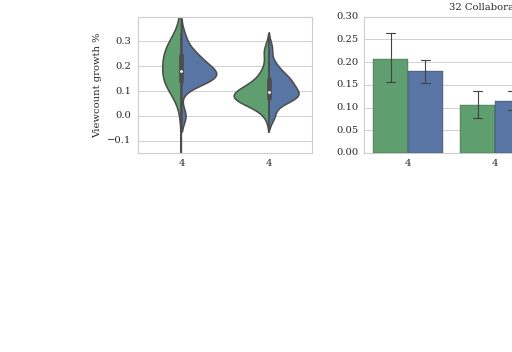

In [143]:
# Effekt von wiederholten kollaborationen? task
# For channel with the most collabs, and different popularities
_from = df_collab_pairs.ix[1490, 'from']
_from_popularity = df_collab_pairs.ix[1490, 'from_popularity']
_to = df_collab_pairs.ix[1490, 'to']
_to_popularity = df_collab_pairs.ix[1490, 'from_popularity']
_weight = df_collab_pairs.ix[1490, 'weight']

from_group = channel_collabs_groups.get_group(_from)
to_group = channel_collabs_groups.get_group(_to)

test = pa.concat([to_group, from_group])
test = test[(test.collab_window=='Collab') | (test.collab_window=='Non_Collab')]



fig = plt.figure()

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
sns.violinplot(x="channelID", y="p_viewCount_gradient", hue='collab_window', data=test, ax=ax1, split=True)
sns.barplot(x="channelID", y="p_viewCount_gradient", hue='collab_window', data=test, ci=99, errwidth=1., capsize=.1, ax=ax2)
ax1.set_xticklabels(['{}'.format(_to_popularity), '{}'.format(_from_popularity)])
ax1.set_xlabel('')
ax1.set_ylabel('Viewcount growth %')
ax2.set_xticklabels(['{}'.format(_to_popularity), '{}'.format(_from_popularity)])
ax2.set_xlabel('Popularity', position=(1.1,0.1))
ax2.set_ylabel('')
#plt.suptitle('{} Collaborations between popularities {}, {}'.format(_weight, _to_popularity, _from_popularity))
ax1.legend_.remove()
ax2.legend_.remove()

ax3 = fig.add_subplot(143, sharey=ax1)
ax4 = fig.add_subplot(144, sharey=ax2)
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.violinplot(x="channelID", y="p_gradient", hue='collab_window', data=test, ax=ax3, split=True)
sns.barplot(x="channelID", y="p_gradient", hue='collab_window', data=test, ci=99, errwidth=1., capsize=.1, ax=ax4)
ax3.set_xticklabels(['{}'.format(_to_popularity), '{}'.format(_from_popularity)])
ax3.set_xlabel('')
ax3.set_ylabel('Subscriber growth %')
ax4.set_xticklabels(['{}'.format(_to_popularity), '{}'.format(_from_popularity)])
ax4.set_xlabel('')
ax4.set_ylabel('')
plt.suptitle('{} Collaborations from popularity {} to {}'.format(_weight, _from_popularity, _to_popularity))
ax4.legend_.remove()
L = ax3.legend(frameon=True,loc='upper center', bbox_to_anchor=(-0.2, -0.1), ncol=2)
L.get_texts()[0].set_text('Collaboration')
L.get_texts()[1].set_text('Non-Collaboration')
ax1.set_ylim([-0.15, 0.4])

#fig.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.9, wspace=0.3)

save_plot('collab_channel_popularity_test.pdf', fig, 4*s_width, s_height)

<IPython.core.display.Javascript object>


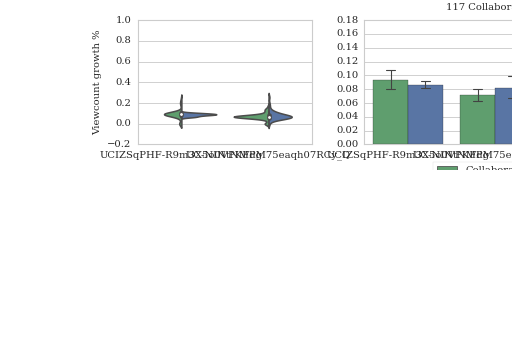

<IPython.core.display.Javascript object>


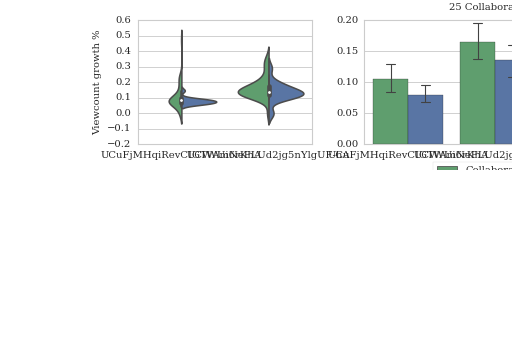

(1321, u'UCz_BJGTYrM4ntr7vsrsjfLw', u'UCcsja3nlq2R1belenHR0j0Q')
(1322, u'UCz_BJGTYrM4ntr7vsrsjfLw', u'UCU4BHh9Dwfd7-I_xTZ5037Q')


<IPython.core.display.Javascript object>


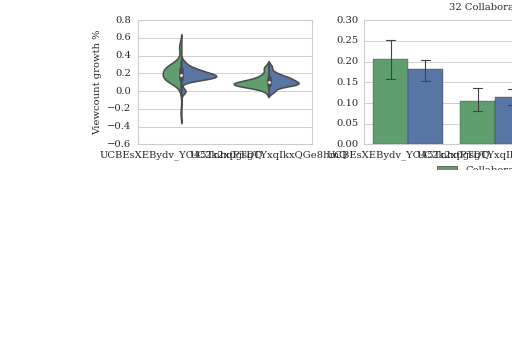

<IPython.core.display.Javascript object>


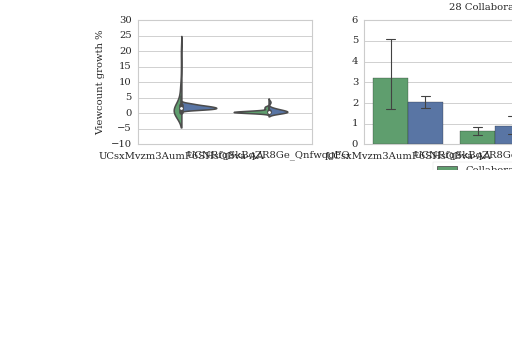

<IPython.core.display.Javascript object>


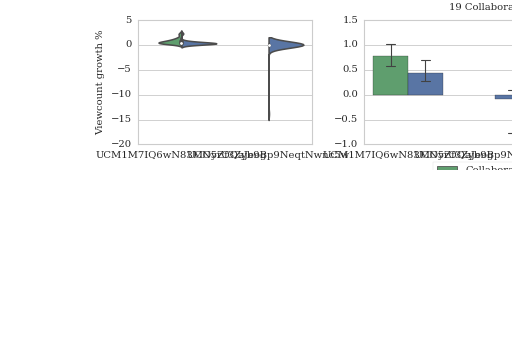

<IPython.core.display.Javascript object>


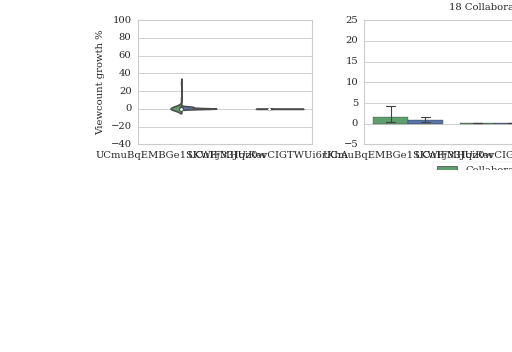

In [146]:
# displaying effect split to collab/non_collab


pdf = matplotlib.backends.backend_pdf.PdfPages(CDIR+'/'+'collab_channel_pair_popularity_combined.pdf')


for i, row in df_collab_pairs.iterrows():
    
    # Effekt von wiederholten kollaborationen? task
    # For channel with the most collabs, and different popularities
    _from = row['from']
    _from_popularity = row['from_popularity']
    _to = row['to']
    _to_popularity = row['to_popularity']
    _weight = row['weight']

    from_group = channel_collabs_groups.get_group(_from)
    to_group = channel_collabs_groups.get_group(_to)

    test = pa.concat([to_group, from_group])
    test = test[(test.collab_window=='Collab') | (test.collab_window=='Non_Collab')]
    
    if len(test['collab_window'].unique()) < 2:
        print (i, _from, _to)
        continue
    
    fig = plt.figure()

    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    sns.violinplot(x="channelID", y="p_viewCount_gradient", hue='collab_window', data=test, ax=ax1, split=True,hue_order=['Collab', 'Non_Collab'])
    sns.barplot(x="channelID", y="p_viewCount_gradient", hue='collab_window', data=test, ci=99, errwidth=1., capsize=.1, ax=ax2,hue_order=['Collab', 'Non_Collab'])
    #ax1.set_xticklabels(['{}'.format(_to_popularity), '{}'.format(_from_popularity)])
    ax1.set_xlabel('')
    ax1.set_ylabel('Viewcount growth %')
    #ax2.set_xticklabels(['{}'.format(_to_popularity), '{}'.format(_from_popularity)])
    ax2.set_xlabel('Popularity', position=(1.1,0.1))
    ax2.set_ylabel('')
    #plt.suptitle('{} Collaborations between popularities {}, {}'.format(_weight, _to_popularity, _from_popularity))
    ax1.legend_.remove()
    ax2.legend_.remove()

    ax3 = fig.add_subplot(143, sharey=ax1)
    ax4 = fig.add_subplot(144, sharey=ax2)
    #fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.violinplot(x="channelID", y="p_gradient", hue='collab_window', data=test, ax=ax3, split=True,hue_order=['Collab', 'Non_Collab'])
    sns.barplot(x="channelID", y="p_gradient", hue='collab_window', data=test, ci=99, errwidth=1., capsize=.1, ax=ax4,hue_order=['Collab', 'Non_Collab'])
    #ax3.set_xticklabels(['{}'.format(_to_popularity), '{}'.format(_from_popularity)])
    ax3.set_xlabel('')
    ax3.set_ylabel('Subscriber growth %')
    #ax4.set_xticklabels(['{}'.format(_to_popularity), '{}'.format(_from_popularity)])
    ax4.set_xlabel('')
    ax4.set_ylabel('')
    plt.suptitle('{} Collaborations from popularity {} to {}'.format(_weight, _from_popularity, _to_popularity))
    ax4.legend_.remove()
    L = ax3.legend(frameon=True,loc='upper center', bbox_to_anchor=(-0.2, -0.1), ncol=2)
    L.get_texts()[0].set_text('Collaboration')
    L.get_texts()[1].set_text('Non-Collaboration')
    #ax1.set_ylim([-0.15, 0.4])
    fig.subplots_adjust(bottom=0.15, top=0.88, wspace=0.3)
    save_plot('collab_channel_pair{}_popularity_{}_{}.pdf'.format(i, _from_popularity, _to_popularity), fig, 4*s_width, s_height)
    pdf.savefig(fig, bbox_inches="tight")
    
pdf.close()

<IPython.core.display.Javascript object>


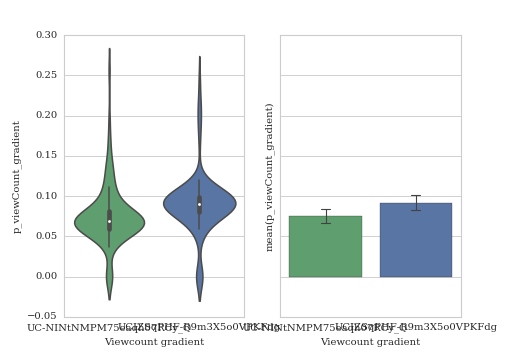

<IPython.core.display.Javascript object>


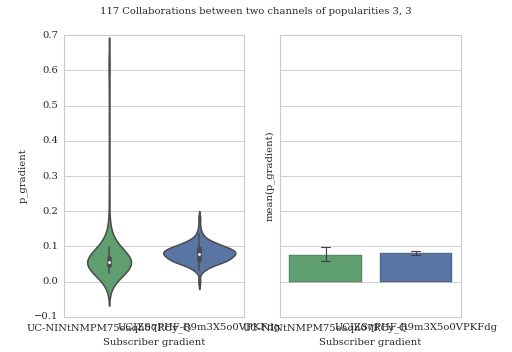

<IPython.core.display.Javascript object>


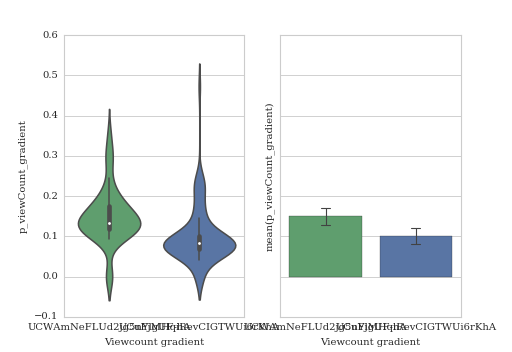

<IPython.core.display.Javascript object>


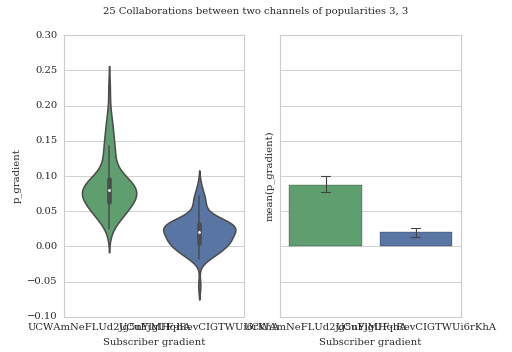

(1321, u'UCz_BJGTYrM4ntr7vsrsjfLw', u'UCcsja3nlq2R1belenHR0j0Q')
(1322, u'UCz_BJGTYrM4ntr7vsrsjfLw', u'UCU4BHh9Dwfd7-I_xTZ5037Q')


<IPython.core.display.Javascript object>


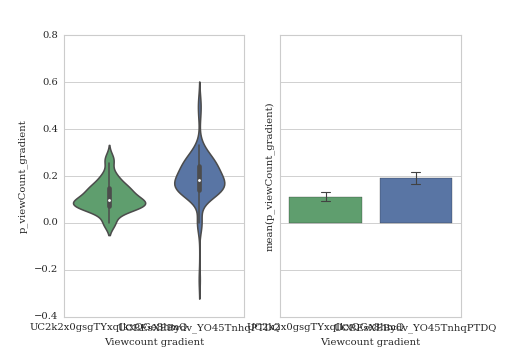

<IPython.core.display.Javascript object>


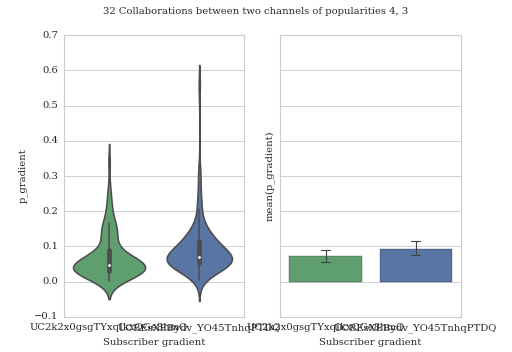

<IPython.core.display.Javascript object>


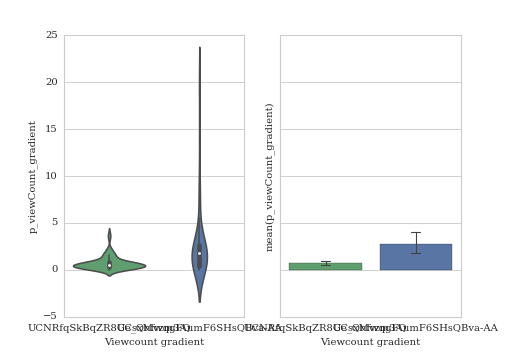

<IPython.core.display.Javascript object>


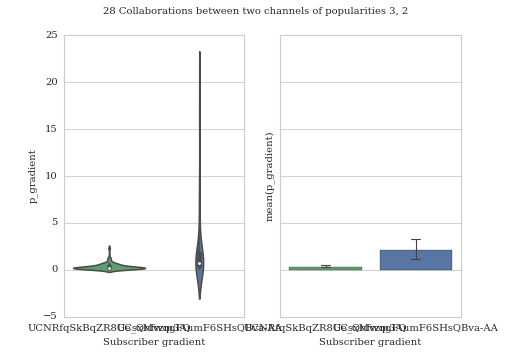

<IPython.core.display.Javascript object>


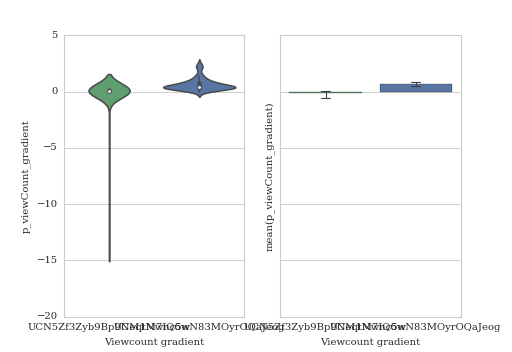

<IPython.core.display.Javascript object>


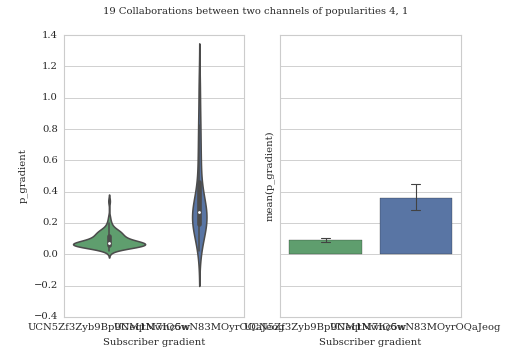

<IPython.core.display.Javascript object>


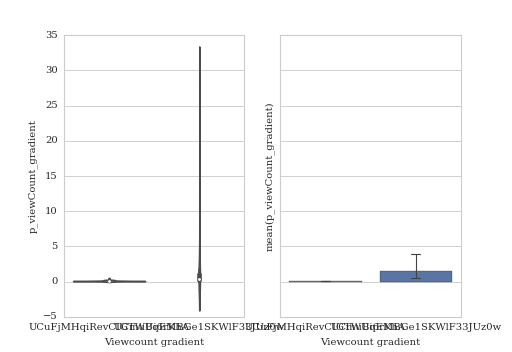

<IPython.core.display.Javascript object>


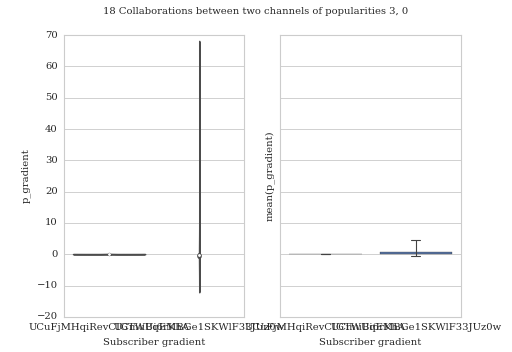

In [145]:
# displaying effect not split to collab/non_collab but single data bar

for i, row in df_collab_pairs.iterrows():
    
    # Effekt von wiederholten kollaborationen? task
    # For channel with the most collabs, and different popularities
    _from = row['from']
    _from_popularity = row['from_popularity']
    _to = row['to']
    _to_popularity = row['to_popularity']
    _weight = row['weight']

    from_group = channel_collabs_groups.get_group(_from)
    to_group = channel_collabs_groups.get_group(_to)

    test = pa.concat([to_group, from_group])
    test = test[(test.collab_window=='Collab') | (test.collab_window=='Non_Collab')]
    
    if len(test['collab_window'].unique()) < 2:
        print (i, _from, _to)
        continue
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.violinplot(x="channelID", y="p_viewCount_gradient", data=test, ax=ax1, order=[_from, _to])
    sns.barplot(x="channelID", y="p_viewCount_gradient", data=test, ci=99, errwidth=1., capsize=.1, ax=ax2, order=[_from, _to])
    #ax1.set_xticklabels(['{}'.format(_from_popularity), '{}'.format(_to_popularity)])
    ax1.set_xlabel('Viewcount gradient')
    #ax2.set_xticklabels(['{}'.format(_from_popularity), '{}'.format(_to_popularity)])
    ax2.set_xlabel('Viewcount gradient')
    #plt.suptitle('{} Collaborations between popularities {}, {}'.format(_weight, _from_popularity, _to_popularity))


    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.violinplot(x="channelID", y="p_gradient", data=test, ax=ax1, order=[_from, _to])
    sns.barplot(x="channelID", y="p_gradient", data=test, ci=99, errwidth=1., capsize=.1, ax=ax2, order=[_from, _to])
    #ax1.set_xticklabels(['{}'.format(_from_popularity), '{}'.format(_to_popularity)])
    ax1.set_xlabel('Subscriber gradient')
    #ax2.set_xticklabels(['{}'.format(_from_popularity), '{}'.format(_to_popularity)])
    ax2.set_xlabel('Subscriber gradient')
    plt.suptitle('{} Collaborations between two channels of popularities {}, {}'.format(_weight, _from_popularity, _to_popularity))